In [1]:
from linescanning import (
    prf,
    optimal,
    pycortex,
    plotting,
    fitting
)
import matplotlib.pyplot as plt
import os
import numpy as np
import cortex
opj = os.path.join
import seaborn as sns
import pandas as pd
import scipy.stats as stats

# for prf analysis
%matplotlib inline
from linescanning import prf, plotting, fitting
from prfpy import model, rf, timecourse
import numpy as np
import os
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
opd = os.path.dirname
opj = os.path.join
from prfpy.stimulus import PRFStimulus2D
import scipy.signal as signal
from nilearn.glm.first_level.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative
#!/usr/bin/env python
#$ -j Y
#$ -cwd
#$ -V
import ast
import getopt
import scipy
from linescanning import (
    prf,
    utils,
    dataset,
    plotting,
    preproc,
    optimal
)
import numpy as np
import nibabel as nb
import pandas as pd
import os
from scipy import io
import sys
import warnings
import json
import pickle
import mkl
mkl.set_num_threads=1
standard_max_threads = mkl.get_max_threads()
from datetime import datetime, timedelta
from linescanning.prf import *
import math
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from past.utils import old_div
from prfpy.stimulus import *
from prfpy.fit import *
from prfpy.model import *
from prfpy import timecourse
import random
from scipy.ndimage import rotate
from scipy import signal, io
import subprocess
import time
import yaml
import cortex
import scipy.stats as stats
from statsmodels.stats.weightstats import DescrStatsW, ttost_paired
from statsmodels.stats.descriptivestats import Description
from seaborn import regression
import statsmodels.api as sm
warnings.filterwarnings('ignore')
opj = os.path.join

import scipy.stats as stats
from statsmodels.stats.weightstats import DescrStatsW, ttost_paired
from statsmodels.stats.descriptivestats import Description
from seaborn import regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from linescanning import prf, optimal, pycortex
import numpy as np

In [2]:
%%capture
import numpy as np
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter 
from prfpy.model import DoG_Iso2DGaussianModel
from prfpy.fit import DoG_Iso2DGaussianFitter 
from prfpy.model import Norm_Iso2DGaussianModel
from prfpy.fit import Norm_Iso2DGaussianFitter 
from prfpy.model import CSS_Iso2DGaussianModel
from prfpy.fit import CSS_Iso2DGaussianFitter 
from linescanning import prf
import os
from prfpy import rf,stimulus
from prfpy.fit import *
from prfpy.model import *
opd = os.path.dirname
opj = os.path.join

#/packages/development/anaconda/3-8/envs/preproc/lib/python3.9/site-packages/jupyter_core/paths.py

qsub -o $DIR_DATA_HOME/derivatives/prf/sub-001/ses-2_train-test -N sub-001_ses-2_test_v3 -q verylong.q -pe smp 10 $DIR_DATA_HOME/code/def_code/function_cv.py --sub 001 --ses 2 --v3 --njobs 10 --verbose  --cv --tc


### Functions

#### Load all subjects class

In [2]:
class AllSubjParams():
    
    '''
    Class to fit specific dog parameter across eccentricity bins for all subjects, using a weighted r2 mean or not (w = True /False) and plot it
        
        y: can be 'yfit'(fitted bins to intercept and slope, estimated using all data) or 'y' (actual data binned)
        
        w: use the weighted mean for r2 or just the mean of the bin . if W = false : median instead of mean is used and no weighted by R2
        
        testprint : show posthoc test parameters or not - it is a ttest using FDR correction
                    ## FDR-corrected post hocs with Cohen's D effect size self.posthoc = pingouin.pairwise_tests(
                    ## uses the parametric ttest() function. If False, use pingouin.wilcoxon() or pingouin.mwu() for paired or unpaired samples, respectively.
                        if 0.01 < p_val < 0.05:txt = "*"
                        elif 0.001 < p_val < 0.01:txt = "**"
                        elif p_val < 0.001:txt = "***"
                    
    It returns a barplot with error of all parameters across both sessions and the points values (bin values). It shows whether differences between sessions for specific parameter are significant or not.
                            
    '''
        
    def __init__(
        self, 
        data=None, 
        par=None, 
        #roi=None, 
        nbins=None, 
        y=None, 
        w=None, 
        figsize=(4,8),
        testprint=False, 
        axs=None,
        **kwargs):
    
    
        ## unify all subjects fitting parameter ###
        
        self.data = data
        self.par = par
        self.rois = data.roi.unique()
        self.nbins = nbins
        self.y = y
        self.w = w
        self.testprint = testprint
        self.figsize = figsize
        self.axs = axs
        self.subjects = data.subject.unique()

        self.regdf = pd.DataFrame()
        
        for sub in self.subjects:
            for roi in self.rois:
                #_, _, self.regr_df, self.x = self.fit_param_bins(
                
                #self.regr_df, self.x = self.fit_param_binss(
                _, _, self.regr_df, self.x = self.fit_param_bins(
                    sub, 
                    roi, 
                    self.par, 
                    self.data[self.data.subject == sub], 
                    self.nbins, 
                    self.w)  
                
                self.regdf = pd.concat([self.regdf, self.regr_df])
                
            self.df = self.regdf[self.regdf.parameter == self.par]
        
        
        if not "ses_short" in list(self.df.columns):
            ses_short = self.df["ses"].values.copy()
            ses_short = np.array([i[:3] for i in ses_short])

            self.df["ses_short"] = ses_short
        
 
        
    def fit_param_bins(self, sub, roi, par, data, nbins, w):
        
        '''
        Function to fit specific dog parameter across eccentricity bins, using a weighted r2 mean or not (w = True /False)
        
        if W = false : median instead of mean is used and no weighted by R2
        '''
        
        binpar ='ecc'#'std_prf_ecc'#'std_size'
        b = np.linspace(0.5, 4.5, nbins)
        x = np.asarray([(b[i]+b[i+1])/2 for i in range(len(b)-1)])
        
        ### data for each session
        s0 = data[(data.roi == roi) & (data.ses == 'placebo')] # data for placebo session(data.subject == sub) & 
        s1 = data[(data.roi == roi) &  (data.ses == 'memantine')] # data for memantine session(data.subject == sub)

    
        ### fitting it to a linear function - estimating intercept and slope ###
        p0 = np.polyfit(s0[binpar], s0[par], 1) # placebo - fitting it to a linear function - finding intercept and slope
        p1 = np.polyfit(s1[binpar], s1[par], 1) # memantine, full = True   - fitting it to a linear function - finding intercept and slope
        
        S0 = sm.add_constant(s0[binpar])
        S1 = sm.add_constant(s1[binpar])
        wp0 = sm.WLS(s0[par], S0, weights=s0['r2']).fit()
        wp1 = sm.WLS(s1[par], S1, weights=s1['r2']).fit()
        #print(wp0.fittedvalues)
        #print(wp0.params)
        
        wyfit0 = np.polyval(wp0.params, x)
        wyfit1 = np.polyval(wp1.params, x)

        ### calculating predicted values ###
        yfit0 = np.polyval(p0, x)
        yfit1 = np.polyval(p1, x)
        
        
        ### get mean values for each bin ###
        y0, std0 = self.return_binned(s0, 
                                        s0[par], 
                                        s0[binpar],
                                        w, 
                                        list(b)) # mean value for the bin - real data

        y1, std1 = self.return_binned(s1, 
                                      s1[par], 
                                      s1[binpar], 
                                      w, 
                                      list(b)) # mean value for each bin - real data
        
        yfit0 = np.polyval(p0, x)
        yfit1 = np.polyval(p1, x)
        
        ### create df with fitted values ###
        
        # df = pd.DataFrame({"fit": np.concatenate(tmp_list), "ix": np.concatenate(tmp_ix), "ses": np.concatenate(tmp_name), "subject": np.concatenate(tmp_subj)})

        regr_df = pd.DataFrame()
        std1 = np.array(std1)
        std0 = np.array(std0)
        regr_df['yfit'] = np.hstack([yfit0, yfit1])
        regr_df['wyfit'] = np.hstack([wyfit0, wyfit1])
        regr_df['y'] = np.hstack([y0, y1])
        regr_df['std'] = np.hstack([std0, std1]) #std of the bin mea    
        #regr_df['ci_l'] = np.hstack([ci_l0, ci_l1]) #std of the bin mean
        regr_df['ses'] = np.hstack([np.repeat('placebo', nbins-1), np.repeat('memantine', nbins-1)])
        regr_df['subject'] = np.repeat(sub, nbins*2-2)
        regr_df['intercept'] = np.hstack([np.repeat(p0[0], nbins-1), np.repeat(p1[0], nbins-1)])    
        regr_df['slope'] = np.hstack([np.repeat(p0[1], nbins-1), np.repeat(p1[1], nbins-1)])
        regr_df['wintercept'] = np.hstack([np.repeat(wp0.params[0], nbins-1), np.repeat(wp1.params[0], nbins-1)])    
        regr_df['wslope'] = np.hstack([np.repeat(wp0.params[1], nbins-1), np.repeat(wp1.params[1], nbins-1)])
        regr_df['diff_fit'] = np.hstack([yfit1-yfit0, yfit1-yfit0]) # memantine - placebo (putting it twice to adjust in df
        regr_df['diff_y'] = np.hstack([y1-y0, y1-y0]) # memantine - placebo (putting it twice to adjust in df
        regr_df['diff_std'] = np.hstack([np.abs(std1-std0), np.abs(std1-std0)]) # memantine - placebo (putting it twice to adjust in df
        regr_df['roi'] = roi
        regr_df['parameter'] = par

        std_resid0 = np.std(y0-yfit0)
        std_resid1 = np.std(y1-yfit1)

        return p0, p1, regr_df, x
    
    
    def fit_param_binss(self, roi, par, data, nbins, w):
        
        '''
        Function to fit specific dog parameter across eccentricity bins, using a weighted r2 mean or not (w = True /False)
        
        We are obtaining the CI of each fit using seaborn regression package
        
        No weighted mean is used here (we only need the fitted differences)
        
        The grid is performed tiny differently (it has 20 values instead of 18 as above)
        '''
        
        binpar ='ecc'#'std_prf_ecc'#'std_size'
        
        b = np.linspace(0.5, 4.5, nbins)
        
        ### data for each session
        s0 = data[(data.roi == roi) & (data.ses == 'placebo')] # data for placebo session(data.subject == sub) & 
        s1 = data[(data.roi == roi)  & (data.ses == 'memantine')] # data for memantine session& (data.subject == sub)

    
        ### fitting it to a linear function - estimating intercept and slope ###
        
        #p0 = np.polyfit(s0[binpar], s0[par], 1) # placebo - fitting it to a linear function - finding intercept and slope

        #p1 = np.polyfit(s1[binpar], s1[par], 1) # memantine, full = True   - fitting it to a linear function - finding intercept and slope

        reg_pla = regression._RegressionPlotter(data = s0, x = 'ecc',  y=par,  x_bins = nbins
                                                , x_ci = None)
        
        reg_mem = regression._RegressionPlotter(data = s1, x = 'ecc',  y=par,  x_bins = nbins
                                                , x_ci = None)

        grid, yhat_pla, err_bands_pla = reg_pla.fit_regression(grid = b) #  return grid, yhat, err_bands
        grid, yhat_mem, err_bands_mem = reg_mem.fit_regression(grid = b) #  return grid, yhat, err_bands

        regr_df = pd.DataFrame()
        regr_df['yfit'] = np.hstack([yhat_pla, yhat_mem])
        regr_df['ci_l'] = np.hstack([err_bands_pla[0], err_bands_mem[0]]) #std of the bin mean
        regr_df['ci_u'] = np.hstack([err_bands_pla[1], err_bands_mem[1]]) #std of the bin mean
        regr_df['ses'] = np.hstack([np.repeat('placebo', nbins), np.repeat('memantine', nbins)])
        #regr_df['subject'] = np.repeat(sub, nbins*2)
        regr_df['diff_fit'] = np.hstack([yhat_mem-yhat_pla, yhat_mem-yhat_pla]) # memantine - placebo (putting it twice to adjust in df)
        regr_df['diff_cil'] = np.hstack([err_bands_mem[0]-err_bands_pla[0], err_bands_mem[0]-err_bands_pla[0]])  # memantine - placebo (putting it twice to adjust in df)
        regr_df['diff_ciu'] = np.hstack([err_bands_mem[1]-err_bands_pla[1], err_bands_mem[1]-err_bands_pla[1]])  # memantine - placebo (putting it twice to adjust in df)
        regr_df['roi'] = roi
        regr_df['parameter'] = par
    
        return regr_df, grid
    
    
    def return_binned(self, data, data_par, binon, w, bins=None, start=None, stop=None, binsize=None, nbins=None):
        
        """
        Bins data according to provided bins. Can provide either a list of bins,
        or start, stop and bin sizes or nbins.

        Equivalent to: scipy.stats.binned_statistic()

        data (1D array) : values to be averaged within a bin
        binon (1D array) : independent values to bin-on (separate from values being averaged)
        bins (list) : list of bins
        start (float) :
        stop (float) :
        binsize (float) :
        nbins (int) :

        Returns
        binned_data (arr)
        
        if W = false : median instead of mean is used and no weighted by R2
        using the wighted mean by r2, the fitting is much closer to it
        
        median is much closer to the fitting as well - avoid outliers having too much influence 
        
        fitting is performed to all data - no bins
        """

        #data=np.asarray(data_par)
        binon=np.asarray(binon)

        assert data_par.ndim,'data must be 1D'

        if not bins and binsize:
            assert start and stop, 'provid list of bins or start and stop values'
            bins=np.arange(start,stop,binsize)
        elif not bins and nbins:
            assert start and stop, 'provid list of bins or start and stop values'
            bins=np.linspace(start,stop,nbins)
        else:
            assert bins, 'provide bins'

        binned = [data_par[(binon >= bins[i]) & (binon<bins[i+1])].median() for i in range(len(bins)-1)] # data=data[par]
        #print(binned)
        std = [data_par[(binon >= bins[i]) & (binon<bins[i+1])].std() for i in range(len(bins)-1)] # not very useful if using the median but good to check outliers?
        
        
        
        if w: # calculate the mean of each bin (made by eccentricity size) by r2 weighted - those voxels with higher explainable variance will have more weight in the mean
            binned = [DescrStatsW(data = data_par[(binon >= bins[i]) & (binon<bins[i+1])], weights = data[(binon >= bins[i]) & (binon<bins[i+1])].r2).mean for i in range(len(bins)-1)]
            std = [DescrStatsW(data = data_par[(binon >= bins[i]) & (binon<bins[i+1])], weights = data[(binon >= bins[i]) & (binon<bins[i+1])].r2).std_mean for i in range(len(bins)-1)]
        
        return np.asarray(binned), std

#### Calulate fwhmax, fwmin

In [3]:
def fwhmax_fwatmin(model, params, normalize_RFs=False, return_profiles=False):
    
    model = model.lower()
    x=np.linspace(-50,50,1000).astype('float32')

    if params.r2 > 0:
        prf = params.prf_ampl * np.exp(-0.5*x[...,np.newaxis]**2 / params.prf_size**2) #params[...,3] * np.exp(-0.5*x[...,np.newaxis]**2 / params[...,2]**2)
        vol_prf =  2*np.pi*params.prf_size**2

        if 'dog' in model or 'norm' in model:
            srf = params.surr_ampl * np.exp(-0.5*x[...,np.newaxis]**2 / params.surr_size**2)
            vol_srf = 2*np.pi*params.surr_size**2

        if normalize_RFs==True:

            if model == 'gauss':
                profile =  prf / vol_prf

            elif model =='dog':
                profile = prf / vol_prf - \
                        srf / vol_srf
        else:
            if model == 'gauss':
                profile = prf
            elif model =='dog':
                profile = prf - srf

        half_max = np.max(profile, axis=0)/2
        fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])


        if 'dog' in model or 'norm' in model:

            min_profile = np.min(profile, axis=0)
            fwatmin = np.abs(2*x[np.argmin(np.abs(profile-min_profile), axis=0)])

            result = fwhmax, fwatmin, half_max
        else:
            result = fwhmax, half_max

    else:
        if 'dog' in model or 'norm' in model:
            result = 0,0,0
        else:
            result = 0,0
            
        profile = np.zeros((x.shape[0],1))
        
    if return_profiles:
        return result, profile.T
    else:
        return result

def fwhmax_fwhmin_allvoxels(data, model, normalize_RFs=False):
    fwhmax = []
    fwhmin = []
    halfmax = []

    for index in range(len(data)): 
        
        if model == 'dog':
            fwhmaxx, fwhminn, halfmaxx = fwhmax_fwatmin(model, params = data.iloc[index], normalize_RFs= normalize_RFs)
            fwhmin.append(float(fwhminn))
        else:
            fwhmaxx, halfmaxx = fwhmax_fwatmin(model, params = data.iloc[index], normalize_RFs= normalize_RFs)
               
        fwhmax.append(float(fwhmaxx))
        halfmax.append(float(halfmaxx))
    
    data['fwhmax']= fwhmax
    data['halfmax'] = halfmax
    
    if model == 'dog':
        data['fwmin'] = fwhmin
    
    # if model =='gauss':
    #     data.columns = ['x', 'y', 'prf_size', 'prf_ampl', 'bold_bsl', 
    #         'r2', 'ecc', 'polar', 'roi','session', 'fwhmax', 'halfmax']
        
    # else:
    #     data['fwhmin'] = fwhmin
    #     data.columns = ['x', 'y', 'prf_size', 'prf_ampl', 'bold_bsl', 'surr_ampl', 'surr_size',
    #    'r2', 'size_ratio', 'suppression_index', 'ecc', 'polar', 'roi',
    #    'session', 'fwhmax', 'halfmax', 'fwmin']
    
    
    return data

In [4]:
class Add_measures():
    
    'To obtain profile, fwhmax, halfmax, fwatmin, min profile'

    def __init__(
        self, 
        data = None, 
        model = None,
        ecc = True,
        #params=None,  
        # roi = None,
        normalize_RFs = False
        ):
            
        self.data = data
        self.model = model
        #self.params = params
        #self.roi = roi
        self.normalize_RFs = normalize_RFs
        self.ecc = ecc
        
        
        self.fwhmax = []
        self.fwhmin = []
        self.halfmax = []
        self.minprofile = [] 
        self.profile_df = pd.DataFrame()
        
        if self.ecc:
            self.data = self.data[(self.data.ecc > 0.5) & (self.data.ecc < 4.51)] # not including those vooxels with higher ecc - not even for the profile
        
        for index in range(len(self.data)):    
            fwhmaxx, halfmaxx, fwhminn,  minprofilee, profile , self.x = self.fwhmax_fwatmin(model = self.model, 
                                                                                   params = self.data.iloc[index], 
                                                                                   normalize_RFs = self.normalize_RFs)  # fwhmax, half_max, [], [], list(profile.T), x
            
            self.fwhmax.append(float(fwhmaxx))
            self.halfmax.append(float(halfmaxx))
            self.profile_df[index] = profile
            
            if self.model == 'dog':
                self.minprofile.append(float(minprofilee))
                self.fwhmin.append(float(fwhminn))
            
        
        self.data['fwhmax']= self.fwhmax
        self.data['halfmax'] = self.halfmax

        if self.model == 'dog':
            self.data['fwmin'] = self.fwhmin
            self.data['min_profile'] = self.minprofile
            
        
        
    
    def fwhmax_fwatmin(self, model, params, normalize_RFs):
    
        model = model.lower()
        x = np.linspace(-20,20,1000).astype('float32')

        prf = params.prf_ampl * np.exp(-0.5*x[...,np.newaxis]**2 / params.prf_size**2) #params[...,3] * np.exp(-0.5*x[...,np.newaxis]**2 / params[...,2]**2)
        vol_prf =  2*np.pi*params.prf_size**2

        if 'dog' in model or 'norm' in model:
            srf = params.surr_ampl * np.exp(-0.5*x[...,np.newaxis]**2 / params.surr_size**2)
            vol_srf = 2*np.pi*params.surr_size**2

        if normalize_RFs==True:

            if model == 'gauss':
                profile =  prf / vol_prf

            elif model =='dog':
                profile = prf / vol_prf - \
                        srf / vol_srf
        else:
            if model == 'gauss':
                profile = prf
            elif model =='dog':
                profile = prf - srf

        half_max = np.max(profile, axis=0)/2
        
        fwhmax = np.abs(2*x[np.argmin(np.abs(profile-half_max), axis=0)])


        if 'dog' in model or 'norm' in model:

            min_profile = np.min(profile, axis=0)
            
            fwatmin = np.abs(2*x[np.argmin(np.abs(profile-min_profile), axis=0)])

            return fwhmax, fwatmin, half_max, min_profile, list(profile.T), x
        else:
            return fwhmax, half_max, [], [], list(profile.T), x

In [5]:
def mean_std_weightedr2(parameter, data, plot  = True):

    ''' 
    Function to calculate the mean and std weighted by R2 of the parameters per session and/all subjects

        parameter: parameter we want to obtain the info from
        
        data: all info regarding the parameters
        
        plot = True : if we want to plot the weighted mean and std for each subject

    '''
    
    weighted = pd.DataFrame()
    
    for sub in data.subject.unique():
        
        weightedr2 = pd.DataFrame()
        
        weightedr2['subject'] = np.repeat(sub, 2) # 2 sessions 
    
        for roi in data.roi.unique():
            
            # if theres more than 1 ROI I should concatenate them too ? --> I have put weighted inside this loop (might be solved)
            
            weightedr2['roi'] = np.repeat(roi, 2) # 2 sessions 
            
            weightedr2['ses'] = data.ses.unique() # 'placebo', 'memantine'
            
            stds, means = [], []
         
            for ses in data.ses.unique():
                
                selected_data = data[(data.roi==roi) & (data.ses==ses) & (data.subject==sub)]
                                           
                std = DescrStatsW(selected_data[parameter], 
                                  weights = selected_data.r2).std_mean # standard deviation of the weighted mean
                
                mean = DescrStatsW(selected_data[parameter], 
                                   weights = selected_data.r2).mean
                
                stds.append(std)
                
                means.append(mean)                
                
            weightedr2['mean'] = means
            
            weightedr2['std'] = stds
        
            weighted = pd.concat([weighted, weightedr2])
    
    ###### plotting mean and std of weighted r2 ####
           
    if plot:
        
        roi = np.arange(len(weighted.roi.unique()))
        
        width = 0.35 

        plt.figure(figsize = (15,6))

        p1 = plt.bar(roi, weighted[weighted.ses == 'placebo'].groupby(['roi'])['mean'].mean(), width, color='#cccc', 
                    yerr=weighted[weighted.ses == 'placebo'].groupby(['roi'])['std'].mean(), ecolor = 'black')

        p2 = plt.bar(roi, weighted[weighted.ses == 'memantine'].groupby(['roi'])['mean'].mean(), width, 
                    yerr=weighted[weighted.ses == 'memantine'].groupby(['roi'])['std'].mean(), 
                    bottom =weighted[weighted.ses == 'placebo'].groupby(['roi'])['mean'].mean(), 
                    ecolor = 'black', color = 'indianred')

        plt.xticks(roi, weighted.roi.unique(), fontsize = 15)

        plt.ylabel(f'{parameter}', fontsize = 15)

        plt.xlabel(f'ROI', fontsize = 15)

        plt.title(f'{parameter} weighted mean by R2', fontsize = 15)

        plt.yticks(fontsize = 15)

        plt.legend((p1[0], p2[0]), ('placebo', 'memantine'), fontsize = 15)

    return weighted


### Load parameters per ROI

In [6]:
## Load parameters ROIs
def load_params_roi(sub, roi, model, cv):
    
    if roi != 'v1':
        roi = roi.upper()
    if cv:
        add = '_train-test'
    else:
        add = ''
    
    ### SESSION 2
    prf_fn_s2 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2{add}", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
    pars_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
    #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
    data_s2 = pars_s2.loc[pars_s2.r2 != 0] 
    #data_s2 = pars_s2.loc[(pars_s2.ecc>0) & (pars_s2.ecc<=5)] # selecting voxels which are true for V1 (whole roi) and ecc higher than 0
    
    data_s2['roi'] = roi
    
    data_s2['session'] = 2
    
    if cv:
        cvrsq_s2 = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}/rsqs_{roi}_2_sub{sub}.csv')
        cvrsq_s2.index = data_s2.index
    else:
        cvrsq_s2 = []
    
    ### SESSION 3
    
    prf_fn_s3 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-3{add}", f"sub-{sub}_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
    pars_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=model).to_df() #gettig prf parameters 
    #data_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=model).to_df() #gettig prf parameters 
            
    data_s3 = pars_s3.loc[pars_s3.r2 != 0] 
    # data_s3 = pars_s3.loc[(pars_s3.ecc>0) & (pars_s3.ecc<=5)] # selecting voxels which are true for V1 (whole roi) and ecc higher than 0

    data_s3['roi'] = roi
    
    data_s3['session'] = 3
    
    if cv:
        cvrsq_s3 = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}/rsqs_{roi}_3_sub{sub}.csv')
        cvrsq_s3.index = data_s3.index
    else:
        cvrsq_s3 = []
    
    if sub in ['003', '004', '007', '012', '016']: # meman session 2
        
        data_s2['ses'] = 'memantine'
        
        data_s3['ses'] = 'placebo'
        
    else:  ## meman in session 3     
        
        data_s3['ses'] = 'memantine'
        
        data_s2['ses'] = 'placebo'

    data = pd.concat([data_s2, data_s3])
    
    data['subject'] = sub
    
    if cv:
        data['rsq_test'] = pd.concat([cvrsq_s2['tc_rsq_test'], cvrsq_s3['tc_rsq_test']])
    
    dataf = Add_measures(data = data, model = model, normalize_RFs = False, ecc = True)
    
    
    #dataf = fwhmax_fwhmin_allvoxels(data = data, model = 'dog', normalize_RFs = False) # calculate fwhmax, fwhmin
    
    #datae = dataf.data[dataf.data.ecc < 5.5]
    
    #datae = dataf[dataf.ecc<5.5]
    
    dataf.data.to_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/sub-{sub}_roi-{roi}_{model}_parameters.csv')
    
    # dataf.data contains the whole dataset
    # dataf.profile contains the profile for each voxel
    
    return dataf, cvrsq_s2, cvrsq_s3

## Load parameters for CVR2 analysis

### DoG-TC cvR2

In [16]:
sub='001'
mod = 'dog'
opt = 'TC' #lbfgs
dogtc_001 = pd.DataFrame()

rois = ['v1', 'V2', 'V3']

for roi in rois:

        prf_fn_s2 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{mod}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
        pars_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=mod).to_df() #gettig prf parameters 
        #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
        data_s2 = pars_s2.loc[pars_s2.r2 != 0] 
        
        dogtc_roi = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2_train-test/rsqs_{roi}_ses-2_sub-{sub}_{opt}.csv') 
        
        #gauss_roi.index = data_s2.index
        dogtc_001 = pd.concat([dogtc_001, dogtc_roi], axis = 0)

dogtc_001.to_csv('dogtc001_parameters.csv')

In [17]:
dogtc_001

,Unnamed: 0,tc_rsq_train,tc_rsq_test
0,0,0.648224,0.492611
1,1,0.694978,0.602094
2,2,0.685644,0.547939
3,3,0.574798,0.576997
4,4,0.506553,0.602072
...,...,...,...
1208,1208,0.621202,0.615606
1209,1209,0.579181,0.425085
1210,1210,0.407549,0.190466
1211,1211,0.568147,0.457365


In [18]:
sub='001'
mod = 'dog'
opt = 'LBFGS' #lbfgs
doglb_001 = pd.DataFrame()

rois = ['v1', 'V2', 'V3']

for roi in rois:

        prf_fn_s2 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{mod}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
        pars_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=mod).to_df() #gettig prf parameters 
        #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
        data_s2 = pars_s2.loc[pars_s2.r2 != 0] 
        
        doglb_roi = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2_train-test/rsqs_{roi}_ses-2_sub-{sub}_{opt}.csv') 
        
        #gauss_roi.index = data_s2.index
        doglb_001 = pd.concat([doglb_001, doglb_roi], axis = 0)

doglb_001.to_csv('doglb001_parameters.csv')

## Timecourse prediction

In [51]:
cvv3 = pd.read_csv('/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/rsqs_even_V3_ses-2_sub-001_allmods.csv')
cvv3

,Unnamed: 0,dog_bgfs_rsq_train,dog_bgfs_rsq_test,gauss_bgfs_rsq_train,gauss_bgfs_rsq_test
0,0,0.431658,-1.797693e+308,0.415057,-1.797693e+308
1,1,0.408102,-1.797693e+308,0.382860,-1.797693e+308
2,2,0.431444,-1.797693e+308,0.371887,-1.797693e+308
3,3,0.340573,-1.797693e+308,0.316088,-1.797693e+308
4,4,0.422042,-1.797693e+308,0.405412,-1.797693e+308
...,...,...,...,...,...
298389,298389,NaN,0.000000e+00,NaN,0.000000e+00
298390,298390,NaN,0.000000e+00,NaN,0.000000e+00
298391,298391,NaN,0.000000e+00,NaN,0.000000e+00
298392,298392,NaN,0.000000e+00,NaN,0.000000e+00


In [23]:
test_pred = pd.read_csv('/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/cvr2_prediction_V1_ses-2_sub-001_allmods.csv')
test_pred
r2_odd = pd.read_csv('/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/rsqs_even_V1_ses-2_sub-001_allmods.csv')
r2_odd.iloc[154186]

Unnamed: 0              154186.000000
cvr2_gauss_bgfs_even      -133.097304
cvr2_dog_tc_even             0.752343
cvr2_dog_bgfs_even           0.714885
Name: 154186, dtype: float64

In [41]:
### for Gaussian
test_predictions = test_pred['testpred_even_V1_gauss_bgfs']/14
test_data= test_pred['test_odd_V1_2']

r2_gauss = np.nan_to_num(1-np.sum((test_data-test_predictions)**2)/(test_data.shape[-1]*test_data.var()))

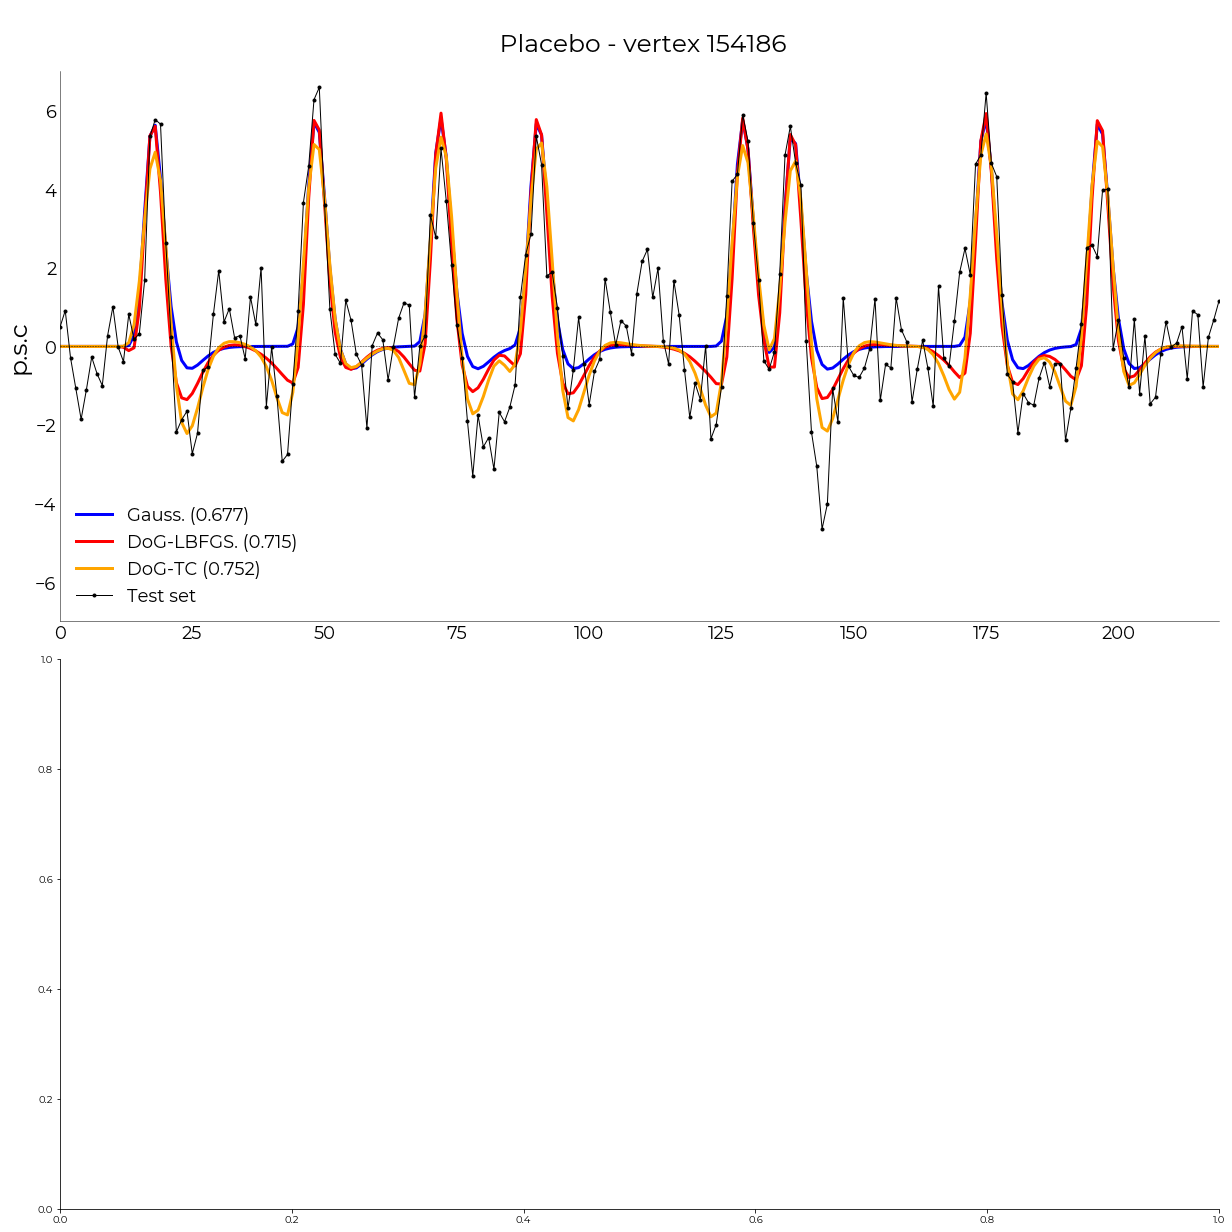

In [47]:
%matplotlib inline
#fig, axs = plt.subplots(2,2,figsize=(26,10),constrained_layout=True)
fig = plt.figure(figsize=(17,17),constrained_layout=True) #
gs = fig.add_gridspec(2,1)#, width_ratios=[5,27])
ax11 = fig.add_subplot(gs[0])
ax22 = fig.add_subplot(gs[1])


ts = [test_pred['testpred_even_V1_gauss_bgfs']/14, 
test_pred['testpred_even_V1_dog_bgfs'], 
test_pred['testpred_even_V1_dog_tc'],
test_pred['test_odd_V1_2']]


labels = [f'Gauss. ({np.round(r2_gauss, 3)})', 
            f'DoG-LBFGS. ({np.round(r2_odd.iloc[154186][3], 3)})',
            f'DoG-TC ({np.round(r2_odd.iloc[154186][2], 3)})', 
            f'Test set '
            ''
            ]

markers=[None,None,None, "."]
line_width=[3, 3, 3, 1]
color=['blue', "red", 'orange','black']

plotting.LazyPlot(
      ts,
      y_lim=[-7,7],
      color = color,
      markers = markers,
      line_width = line_width,
      axs=ax11,
      title= ' \n Placebo - vertex 154186',
      y_label="p.s.c",
      add_hline=0,
      font_size = 25,
      labels = labels,
      label_size = 18)

In [26]:
statistic(x,y,0)

-0.030968401570548032

-0.03096840157054903
3.3333322222225924e-07


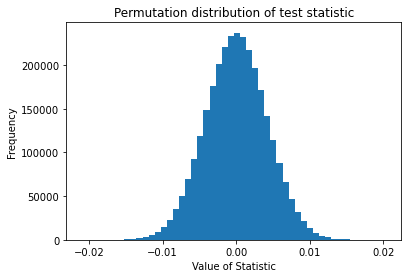

In [34]:
from scipy.stats import permutation_test

x = doglb_001['bgfs_rsq_test']
y= dogtc_001['tc_rsq_test']

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

statistic(x,y,0)
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed
res = permutation_test((x, y), statistic, vectorized=True,
                        n_resamples=3000000, alternative='less')
print(res.statistic)

print(res.pvalue)

import matplotlib.pyplot as plt
plt.hist(res.null_distribution, bins=50)
plt.title("Permutation distribution of test statistic")
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.show()

#Indeed, the test statistic is negative, suggesting that the true mean of the distribution underlying x is less than that of the distribution underlying y. To determine the probability of this occuring by chance if the two samples were drawn from the same distribution, we perform a permutation test. 

#The approximate probability of obtaining a test statistic less than or equal to the observed value under the null hypothesis is 0.0225%. This is again less than our chosen threshold of 5%, so again we have significant evidence to reject the null hypothesis in favor of the alternative.

### Pycortex CVR2

In [ ]:
r2_v = pycortex.Vertex2D_fix(
    pars2.r2.values,
    data2 = pars2.ecc.values,
    subject="sub-001",
    cmap="magma",
    vmin1=0.1,
    vmax1=0.9,
    vmin2=0,
    vmax2 = 5
)

In [ ]:
import os
model = 'dog'
ctx_save = pycortex.SavePycortexViews(
    data, 
    subject='sub-001',
    fig_dir=os.path.dirname(prff),
    base_name=f"sub-001_ses-2_task-2R_rois_model-{model}_stage-iter_lbfgs",
    pivot=0,
    radius=260
    )

In [ ]:

ctx_save.save_all(
    gallery=True, 
    n_cols=4, 
    add_cms=True,
    cb=[200,900,900,1700],
    y=1.08,
    title = 'Placebo lbfgs',
    )

# do it for placebo and memantine

### ses-3 Memantine

In [5]:
sub='001'
mod_ses3 = pd.DataFrame()
ses = 'ses-3'

models = ['dogtc', 'dogbfgs', 'gauss']
rois = ['v1', 'V2', 'V3']
for mods in models:
        opt = 'LBFGS'
        mod = 'dog'
        if mods == 'dogtc':
                opt = 'TC'
        if mods == 'gauss':
                mod = 'gauss'
        
        doglb_001 = pd.DataFrame()
        for roi in rois:

                # prf_fn_s3 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"{ses}", f"sub-{sub}_{ses}_task-2R_roi-{roi}_model-{mod}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
        
                # pars_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=mod).to_df() #gettig prf parameters 
                # #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
                # data_s3 = pars_s3.loc[pars_s3.r2 != 0] 
                
                doglb_roi = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/{ses}_train-test/rsqs_{roi}_{ses}_sub-{sub}_{opt}.csv') 
                
                #gauss_roi.index = data_s2.index
                doglb_001 = pd.concat([doglb_001, doglb_roi], axis = 0)
        mod_ses3 = pd.concat([mod_ses3, doglb_001], axis = 1)

mod_ses3.to_csv(f'sub-001_{ses}_parameters_cvr2.csv')

In [6]:
mod_ses3

,Unnamed: 0,tc_rsq_train,tc_rsq_test,Unnamed: 0,bgfs_rsq_train,bgfs_rsq_test,Unnamed: 0,bgfs_rsq_train,bgfs_rsq_test
0,0,0.596040,0.497509,0,0.559108,0.420061,0,0.559108,0.420061
1,1,0.708693,0.539951,1,0.706429,0.545679,1,0.706429,0.545679
2,2,0.669816,0.594249,2,0.630690,0.526035,2,0.630690,0.526035
3,3,0.624946,0.488015,3,0.573612,0.456696,3,0.573612,0.456696
4,4,0.558727,0.383524,4,0.507149,0.345232,4,0.507149,0.345232
...,...,...,...,...,...,...,...,...,...
1194,1194,0.575486,0.498590,1194,0.518736,0.397631,1194,0.518736,0.397631
1195,1195,0.657164,0.566834,1195,0.621823,0.526227,1195,0.621823,0.526227
1196,1196,0.629512,0.514501,1196,0.582167,0.456450,1196,0.582167,0.456450
1197,1197,0.644944,0.502287,1197,0.608199,0.447129,1197,0.608199,0.447129


## Example timecourse predictions (Gauss, DoG-TC, DoG-LBFGS)

### Functions

#### Load dm

In [ ]:
def load_dm(cut_volumes = True):
    
    #### load design matrix ###
    screen_size_cm =39.3
    screen_distance_cm=210
    grid_nr = 20
    TR= 1.5
    
    if cut_volumes:
        n_volumes = 5
    else:
        n_volumes = 0

    design = prf.read_par_file(opj(opd(opd(prf.__file__)), '/data1/projects/Meman1/projects/pilot/code', 'design_task-2R.mat'))

    prf_stim = PRFStimulus2D(screen_size_cm = screen_size_cm,
                                screen_distance_cm = screen_distance_cm,
                                design_matrix = design[:, :, n_volumes:], # remove first 5 volumes
                                TR = TR,
                                task_names ='2R')
    
    return design, prf_stim

#### Load timecorses of subject and parameters- defining which session is placebo/memantine

In [ ]:
def load_sub(sub, roi, model, cv):
    
    if cv:
        test = '_test'
        add = '_train-test'
    else:
        test = '_test' # took out the condition -- added try
        add = ''
    
    if sub in ['003', '004', '007', '012', '016']: # meman session 2
        
        try:
            timecourse_mem = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy'))) 
            timecourse_pla = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy'))) 
        except:
            FileNotFoundError()
            print('not found')
            timecourse_mem = []
            timecourse_pla = []
        
        timecourse_mem_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy'))) 
        timecourse_pla_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy'))) 
        
        prf_mem = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2{add}", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
        prf_pla = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-3{add}", f"sub-{sub}_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
        
    else:  ## meman in session 3     
        
        try:
            timecourse_pla = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy'))) 
            timecourse_mem = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold{test}.npy')))
        except:
            FileNotFoundError()
            print('not found')
            timecourse_mem = []
            timecourse_pla = []
        
        timecourse_pla_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}', f'sub-{sub}_ses-2_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy'))) 
        timecourse_mem_train = pd.DataFrame(np.load(opj(opd(opd(prf.__file__)), f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}', f'sub-{sub}_ses-3_task-2R_roi-{roi}_hemi-LR_desc-avg_bold.npy')))    
        
        prf_pla = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2{add}", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
        prf_mem = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-3{add}", f"sub-{sub}_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") 
    
    return timecourse_mem, timecourse_pla, prf_mem, prf_pla, timecourse_mem_train, timecourse_pla_train

In [ ]:
def load_params_roi(sub, roi, model, cv):
    
    if cv:
        add = '_train-test'
    else:
        add = ''
    
    ### SESSION 2
    prf_fn_s2 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-2{add}", f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
    pars_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
    #data_s2 = prf.Parameters(prf.read_par_file(prf_fn_s2), model=model).to_df() #gettig prf parameters 
    data_s2 = pars_s2.loc[pars_s2.r2 != 0] 
    #data_s2 = pars_s2.loc[(pars_s2.ecc>0) & (pars_s2.ecc<=5)] # selecting voxels which are true for V2 (whole roi) and ecc higher than 0
    
    data_s2['roi'] = roi
    
    data_s2['session'] = 2
    
    if (cv) & (model == 'dog'):
        cvrsq_s2 = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-2{add}/rsqs_{roi}_2_sub{sub}.csv')
        cvrsq_s2.index = data_s2.index
    else:
        cvrsq_s2 = []
    
    ### SESSION 3
    
    prf_fn_s3 = opj("/data1/projects/Meman1/projects/pilot/derivatives/prf",f'sub-{sub}', f"ses-3{add}", f"sub-{sub}_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl") #f"sub-{sub}_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    
    pars_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=model).to_df() #gettig prf parameters 
    #data_s3 = prf.Parameters(prf.read_par_file(prf_fn_s3), model=model).to_df() #gettig prf parameters 
            
    data_s3 = pars_s3.loc[pars_s3.r2 != 0] 
    # data_s3 = pars_s3.loc[(pars_s3.ecc>0) & (pars_s3.ecc<=5)] # selecting voxels which are true for V2 (whole roi) and ecc higher than 0

    data_s3['roi'] = roi
    
    data_s3['session'] = 3
    
    if (cv) & (model == 'dog'):
        cvrsq_s3 = pd.read_csv(f'/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-{sub}/ses-3{add}/rsqs_{roi}_3_sub{sub}.csv')
        cvrsq_s3.index = data_s3.index
    else:
        cvrsq_s3 = []
    
    if sub in ['003', '004', '007', '012', '016']: # meman session 2
        
        data_s2['ses'] = 'memantine'
        
        data_s3['ses'] = 'placebo'
        
    else:  ## meman in session 3     
        
        data_s3['ses'] = 'memantine'
        
        data_s2['ses'] = 'placebo'

    data = pd.concat([data_s2, data_s3])
    
    data['subject'] = sub
    
    if (cv) & (model == 'dog'):
        data['rsq_test'] = pd.concat([cvrsq_s2['tc_rsq_test'], cvrsq_s3['tc_rsq_test']])
    
    return data, cvrsq_s2, cvrsq_s3

In [ ]:
def load_params_object(sub, roi, model, cv):
    
    
    #### load parameters and timecourses of both sessions ####
    
    timecourse_mem, timecourse_pla, prf_mem, prf_pla, timecourse_mem_train, timecourse_pla_train = load_sub(sub, roi, model, cv) #timecourse_mem, timecourse_pla, prf_mem, prf_pla, timecourse_mem_train, timecourse_pla_train
    
    #### load design matrix ####
    
    design, _ = load_dm()  # cut_volumes????
    
    if cv == False:
        timecourse_pla = timecourse_pla_train
        timecourse_mem = timecourse_mem_train
    
    #### load prf parameters and timecourse as an object ####
    
    obj_plac = prf.pRFmodelFitting(
        timecourse_pla.T.values,
        design_matrix = design,
        model = model,
        stage = "iter",
        verbose = False
    )

    obj_plac.load_params(prf_pla, model= model, stage="iter")

    obj_mem = prf.pRFmodelFitting(
        timecourse_mem.T.values,
        design_matrix = design,
        model = model,
        stage = "iter",
        verbose = False
    )

    obj_mem.load_params(prf_mem, model= model, stage="iter")

    return obj_mem, obj_plac

#### Plot to compare models

In [ ]:
def plot_comparison(vox_number, sub, session, roi, n_voxels, cv, design, prf_stim):
    
    ''' 
    param_data_tccv, _, _ = load_params_roi(sub, roi, model, cv)
    
    session = session we want to take the best fitting voxel from 
    
    vox_number : position in the best fitting list (out of 10) or the vox_number desired to plot (when n_voxels = 0)
    
    param_bestfit_data : df containing the n best fitting voxels for each roi and session
    '''
    
    timecourse_mem, timecourse_pla, _, _ , timecourse_mem_train, timecourse_pla_train = load_sub(sub, roi, 'gauss', cv) # model does not matter (only loading timecourse)
    
    
    param_data_gauss, _, _ = load_params_roi(sub, roi, 'gauss', cv) # data with roi of a subject for both sessions
    param_data_dog, _, _ = load_params_roi(sub, roi, 'dog', cv) # data with roi of a subject for both sessions
    
    if n_voxels == 0:
        vox_nr = vox_number 
    else: 
        # param_bestfit_data = best_fit_voxels_roi(data = param_data_dog, n_voxels = n_voxels)

        # vox_nrs = list(param_bestfit_data[(param_bestfit_data.subject== sub) &(param_bestfit_data.ses== session) & (param_bestfit_data.roi==roi)].index) 
        
        # vox_nr = vox_nrs[vox_number]
    
    #### memantine lbfgs ####
    gauss_mem = prf.pRFmodelFitting(
        np.array(timecourse_mem_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="gauss",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,
        constraints = 'bgfs'# fix the BOLD baseline at 0,
    )
    gauss_mem.fit()
    dog_lb_mem = prf.pRFmodelFitting(
        np.array(timecourse_mem_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="dog",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,      # fix the BOLD baseline at 0
        previous_gaussian_fitter = gauss_mem,
        old_params=gauss_mem.gauss_iter,
        constraints = 'bgfs'
    )
    dog_lb_mem.fit()
    params_dog_lb_mem, _, _, pred_dog_lb_mem = dog_lb_mem.plot_vox(title="pars", axis_type="volumes" , stage = 'iter', add_tc ='tc', model='dog', make_figure = False)
    
      #### placebo lbfgs ####
    gauss_pla = prf.pRFmodelFitting(
        np.array(timecourse_pla_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="gauss",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,
        constraints = 'bgfs'# fix the BOLD baseline at 0,
    )
    gauss_pla.fit()
    dog_lb_pla = prf.pRFmodelFitting(
        np.array(timecourse_pla_train[vox_nr]).reshape(1,220),
        design_matrix=design,
        TR=1.5,                     # default
        model="dog",              # default, can be 'gauss', 'css', 'dog', 'norm'
        stage="iter",               # default
        verbose=0,               # keep track of what we're doing,
        fix_bold_baseline=True,      # fix the BOLD baseline at 0
        previous_gaussian_fitter = gauss_pla,
        old_params=gauss_pla.gauss_iter,
        constraints = 'bgfs'
    )
    dog_lb_pla.fit()
    params_dog_lb_pla, _, _, pred_dog_lb_pla = dog_lb_pla.plot_vox(title="pars", axis_type="volumes" , stage = 'iter', add_tc ='tc', model='dog', make_figure = False)
    
    
    ##### Gaussian ####
    n = 7
    placebo_params_gauss = param_data_gauss[param_data_gauss.ses == 'placebo'] # obtain parameters for the session
    prf_pars_pla_gauss = list(placebo_params_gauss.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_placebo_gauss = return_prediction('gauss', prf_stim, design, *prf_pars_pla_gauss) # make prediction based on parameters
    
    memantine_params_gauss =  param_data_gauss[param_data_gauss.ses == 'memantine'] # obtain parameters for the session
    prf_pars_mem_gauss = list(memantine_params_gauss.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_memantine_gauss = return_prediction('gauss', prf_stim, design, *prf_pars_mem_gauss) # make prediction based on parameters
        
    ###### DoG ######
    n =9
    placebo_params_dog = param_data_dog[param_data_dog.ses == 'placebo'] # obtain parameters for the session
    prf_pars_pla_dog = list(placebo_params_dog.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_placebo_dog = return_prediction('dog', prf_stim, design, *prf_pars_pla_dog) # make prediction based on parameters
    
    memantine_params_dog =  param_data_dog[param_data_dog.ses == 'memantine'] # obtain parameters for the session
    prf_pars_mem_dog = list(memantine_params_dog.loc[vox_nr][:-n]) # select only parameters (not ecc, polar, si)
    pred_memantine_dog = return_prediction('dog', prf_stim, design, *prf_pars_mem_dog) # make prediction based on parameters
    
            
    #prf_array_mem_dog = make_prf('dog', prf_stim, prf_pars_mem_dog) # making prf (rf)
    
    #prf_array_pla_dog = make_prf('dog', prf_stim, prf_pars_pla_dog) # making prf (rf)

    '''plotting both sessions timecourses and its prediction of the best fitting voxel for the specified session'''

    %matplotlib inline
    #fig, axs = plt.subplots(2,2,figsize=(26,10),constrained_layout=True)
    fig = plt.figure(figsize=(17,17),constrained_layout=True) #
    gs = fig.add_gridspec(2,1)#, width_ratios=[5,27])
    ax11 = fig.add_subplot(gs[0])
    ax22 = fig.add_subplot(gs[1])
    # ax1 = fig.add_subplot(gs[0,0])
    # ax11 = fig.add_subplot(gs[0,1])
    # ax2 = fig.add_subplot(gs[1,0])
    # ax22 = fig.add_subplot(gs[1,1])
    #sf1 = fig.subfigures(ncols=2, width_ratios=[0.2,1])
    #sf2 = fig.subfigures(ncols=2, width_ratios=[0.2,1])
    #axs[0].title('vox')

    ##### PLACEBO #######
    
    # make plot for rf
    # plotting.LazyPRF(
    #     prf_array_pla_dog, 
    #     vf_extent=[-5, 5], 
    #     ax=ax1,
    #     title = 'Placebo'
    #     )

    labels = [f'Gauss. ({np.round(placebo_params_gauss.r2.loc[vox_nr], 3)})', 
              f'DoG trust-c. ({np.round(placebo_params_dog.r2.loc[vox_nr], 3)})',
              f'DoG lbfgs ({np.round(params_dog_lb_pla[-1], 3)})', 
              #f'Train set '
              ''
              ]
    ts = [pred_placebo_gauss.T, 
          pred_placebo_dog.T, 
          pred_dog_lb_pla,
          timecourse_pla_train[vox_nr]]
    markers=[None,None,None, "."]
    line_width=[3, 3, 3, 1]
    color=['blue', "red", 'orange','black']
    
    plotting.LazyPlot(
       ts,
       color = color,
       markers = markers,
       line_width = line_width,
       axs=ax11,
       title= ' \n Placebo',
       y_label="p.s.c",
       add_hline=0,
       font_size = 25,
       labels = labels,
       label_size = 18)
 
    #### MEMANTINE ####
    
    # plot rf
    # plotting.LazyPRF(
    #     prf_array_mem_dog, 
    #     vf_extent=[-5, 5], 
    #     ax=ax2,
    #     title= 'Memantine'
    #     )
    
    
    labels = [f'Gauss. ({np.round(memantine_params_gauss.r2.loc[vox_nr], 3)})', 
              f'DoG trust-c. ({np.round(memantine_params_dog.r2.loc[vox_nr], 3)})',
              f'DoG lbfgs ({np.round(params_dog_lb_mem[-1], 3)})', 
              f'Train set ']
    ts = [pred_memantine_gauss.T, 
          pred_memantine_dog.T, 
          pred_dog_lb_mem,
          timecourse_mem_train[vox_nr]]
    markers=[None,None,None, "."]
    line_width=[3, 3, 3, 1]
    color=['blue', "red", 'orange','black']
    
    plotting.LazyPlot(
        ts,
        color = color,
       markers = markers,
       line_width = line_width,
       axs=ax22,
       title= '\n Memantine',
       y_label="p.s.c",
       add_hline=0,
       x_label = '\n volumes',
       labels = labels,
       font_size = 25,
       label_size = 18
    )
    
    plt.suptitle(f'sub-{sub} ({roi}) - vox {vox_nr}', fontsize = 27)
        
    
    return 

### Example timecourse

In [ ]:
sub, model, roi, cv, n_voxels, vox_number, session = '001', 'dog', 'V3', False, 10, 0, 'placebo'

design, prf_stim = load_dm()

param_data_tccv, _, _ = load_params_roi(sub, roi, model, cv) # data with roi of a subject for both sessions

plot_comparison(vox_number, sub, session, roi,  n_voxels, cv, design[:,:,5:], prf_stim)

## Load parameters all ROIS

### Load parameters

In [14]:
rois = ['v1', 'v2', 'v3']
subjects = [ '001']#,'005','007', '008', '010', '012'] 
model = 'gauss'
cv = False

parameters_subs = pd.DataFrame()
profilesx_subs = pd.DataFrame()
profilesy_subs = pd.DataFrame()

for sub in subjects:
    print(sub)
    
    for roi in rois:
        print(roi)
        
        param_sub, _, _ = load_params_roi(sub, roi, model, cv = False)
    
        parameters_subs = pd.concat([parameters_subs, param_sub.data], axis = 0) #parameters
        
        # profilex, std_plax, std_memx, profiley, std_play, std_memy = wmean_profile_2d(param_sub, roi) # weighted mean of profiles (not parameters)    
        # profilesx_subs = pd.concat([profilesx_subs, list(profilex)], axis = 0)
        # profilesy_subs = pd.concat([profilesy_subs, list(profiley)], axis = 0)

        # plotting.LazyPlot(
        #     ts = [profilex.loc[1][3:],
        #           profiley.loc[0][3:]],
        #     xx = param_sub.x, # I could reduce it
        #     color = ['indianred', 'black'],
        #     labels = ['memantine', 'placebo'],
        #     title = f'Mean profile sub-{sub} ({roi.upper()})',
        #     x_label = 'x (deg of visual field)',
        #     y_label = f'amplitude - {model} model',
        #     figsize = [10,10],
        #     #markers = [None, '.'],
        #     line_width  = [3,2],
        #     font_size = 30,
        #     #save_as = f"/data1/projects/Meman1/projects/pilot/code/results_images/medianprofile_sub-{sub}_roi-{roi}.jpg"
        #     #save_as = f"/data1/projects/Meman1/projects/pilot/code/results_images/wmeanprofile_sub-{sub}_roi-{roi}_{model}.jpg"
            
        # )
        
print(np.unique(parameters_subs.subject))

parameters_subs.to_csv(f'sub-001_parameters_{model}.csv')

001
v1
v2
v3
['001']


In [2]:
s001_dog_parameters = pd.read_csv('sub-001_parameters_dog.csv')

s001_gauss_parameters = pd.read_csv('sub-001_parameters_gauss.csv')

s001_gauss_parameters.set_index('Unnamed: 0', inplace=True, drop = True) #setting voxel number as index

s001_dog_parameters.set_index('Unnamed: 0', inplace=True, drop = True) #setting voxel number as index

s001_dog_parameters['model']= 'dog'

s001_gauss_parameters['model'] = 'gauss'


s001_parameters = pd.concat([s001_gauss_parameters, s001_dog_parameters], axis = 0)

### Dataset statistics

In [17]:
s001_dog_parameters = pd.read_csv('sub-001_parameters_dog.csv')

s001_gauss_parameters = pd.read_csv('sub-001_parameters_gauss.csv')

model = 'dog'

data_stats = s001_dog_parameters.groupby(['subject', 'ses','roi']).describe()

data_stats.to_csv(f'df_statistics_sub001_{model}.csv')

data_stats

Unnamed: 0                                      \
                           count           mean           std    min   
subject ses       roi                                                  
1       memantine V2       878.0   98533.749431  87146.546597  806.0   
                  V3      1051.0  102031.020932  88984.043379   21.0   
                  v1       785.0  130032.782166  85274.846052  768.0   
        placebo   V2      1012.0   90553.309289  86090.524845  806.0   
                  V3      1101.0  101058.782925  89449.061163   21.0   
                  v1       779.0  116202.908858  87597.067322  768.0   

                                                                      x  \
                             25%       50%        75%       max   count   
subject ses       roi                                                     
1       memantine V2     4691.25  145007.5  152454.75  297239.0   878.0   
                  V3     5231.50  149315.0  153373.00  298367.0  1051.0   
                  v1   125382.00  151222.0  153378.00  298172.0   785.0   
        placebo   V2     3858.75  132640.0  152090.25  297239.0  1012.0   
                  V3     4719.00  149282.0  152984.00  298367.0  1101.0   
                  v1     3892.50  150926.0  152936.50  298172.0   779.0   

                                 ...     fwmin           min_profile  \
                           mean  ...       75%       max       count   
subject ses       roi            ...                                   
1       memantine V2   0.118972  ...  0.009458  0.024603       878.0   
                  V3  -0.083202  ...  0.006502  0.022013      1051.0   
                  v1  -0.539883  ...  0.010915  0.024854       785.0   
        placebo   V2   0.365266  ...  0.009273  0.086764      1012.0   
                  V3   0.128055  ...  0.006510  0.023514      1101.0   
                  v1  -0.321432  ...  0.009891  0.048446       779.0   

                                                                         \
                           mean       std       min       25%       50%   
subject ses       roi                                                     
1       memantine V2  -0.001671  0.000854 -0.005166 -0.002136 -0.001531   
                  V3  -0.001285  0.000734 -0.004697 -0.001549 -0.001134   
                  v1  -0.002023  0.000949 -0.005806 -0.002552 -0.001800   
        placebo   V2  -0.005550  0.122440 -3.896651 -0.002247 -0.001497   
                  V3  -0.001241  0.000694 -0.004838 -0.001530 -0.001174   
                  v1  -0.003494  0.044227 -1.236099 -0.002429 -0.001873   

                                               
                            75%           max  
subject ses       roi                          
1       memantine V2  -0.001023 -1.954754e-04  
                  V3  -0.000810  0.000000e+00  
                  v1  -0.001295 -3.531201e-04  
        placebo   V2  -0.001040 -1.965637e-08  
                  V3  -0.000796  0.000000e+00  
                  v1  -0.001289  0.000000e+00  

[6 rows x 144 columns]

## Pycortex inflated surface

#### Ses-2

In [23]:
## GAUSS - load rois
prff = '/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/sub001_lbfgs_param//sub-001_ses-2_task-2R_model-gauss_stage-iter_desc-prf_params.pkl'
pars = prf.Parameters(prf.read_par_file(prff), model="gauss").to_df()

surfs = {}
for roi in ["V1","V2","V3"]:
    surfs[roi] = optimal.SurfaceCalc(subject="sub-001", fs_label = f'custom.{roi}')
    

# surfsv1 = optimal.SurfaceCalc(subject="sub-001", fs_label = 'custom.V1')#, fs_dir = '/data1/projects/Meman1/projects/pilot/derivatives/freesurfer')

# surfsv2 = optimal.SurfaceCalc(subject="sub-001", fs_label = 'custom.V2')

# surfsv3 = optimal.SurfaceCalc(subject="sub-001", fs_label = 'custom.V3')

### DOG 

model = 'dog'

prf_fn = f"/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-2R_roi-v1_model-{model}_stage-iter_desc-prf_params.pkl"
prf_fn2 ='/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/sub001_lbfgs_param/sub-001_ses-2_task-2R_model-dog_stage-iter_desc-prf_params.pkl'
pars = prf.Parameters(prf.read_par_file(prf_fn), model=model).to_df()
pars22 = prf.Parameters(prf.read_par_file(prf_fn2), model=model).to_df()

for roi in ['V2', 'V3']:
    prf_fn = f"/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2/sub-001_ses-2_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    pars2 = prf.Parameters(prf.read_par_file(prf_fn), model=model).to_df()

    pars.update(pars2[pars2.r2!=0])

pars

,x,y,prf_size,prf_ampl,bold_bsl,surr_ampl,surr_size,r2,size ratio,suppression index,ecc,polar
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
298389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
298390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
298391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
298392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0


In [24]:
# pars[pars.r2!=0] = pars22[pars22.index.isin(pars[pars.r2!=0].index)]
# print(pars22.loc[21], pars.loc[21])

pars2 = fwhmax_fwhmin_allvoxels(pars, model, normalize_RFs=False)

In [33]:
## getting all the values for plotting the surface (inflated)
polar = pycortex.Vertex2D_fix(
    pars2.polar.values,
    data2=pars2.r2.values,
    subject="sub-001",
    cmap="hsvx2",
    vmin1=-3.14,
    vmax1=3.14,
    vmin2=0,
    vmax2=0.8
)

r2_v = pycortex.Vertex2D_fix(
    pars2.r2.values,
    data2 = pars2.ecc.values,
    subject="sub-001",
    cmap="magma",
    vmin1=0.1,
    vmax1=0.9,
    vmin2=0,
    vmax2 = 5
)

fwhmax =  pycortex.Vertex2D_fix(
    pars2.fwhmax.values,
    subject="sub-001",
    cmap="magma",
    vmin1=0,
    vmax1=4,
)

if model == 'dog':
    fwmin =  pycortex.Vertex2D_fix(
        pars2.fwmin.values,
        subject="sub-001",
        cmap="magma",
        vmin1=0,
        vmax1=9,
    )

ecc_v = pycortex.Vertex2D_fix(
    pars2.ecc.values,
    data2=pars2.r2.values,
    subject="sub-001",
    cmap="nipy_spectral",
    vmin1=0,
    vmax1=4.5,
    vmin2=0.1,
    vmax2=0.9
)

# v1 = pycortex.Vertex2D_fix(
#     surfsv1.whole_roi,
#     subject="sub-001",
#     cmap="magma",
#     0,
#     1,
# )

# v2 = pycortex.Vertex2D_fix(
#     surfsv2.whole_roi,
#     "sub-001",
#     "magma",
#     0,
#     1,
# )

# v3 = pycortex.Vertex2D_fix(
#     surfsv3.whole_roi,
#     "sub-001",
#     "magma",
#     0,
#     1
# )

if model == 'dog':
    data = {
        "r2": r2_v,
        # "v1": v1,
        # "v2": v2,
        # "v3": v3,
        'fwhmax': fwhmax,
        'fwmin': fwmin
        }
else:
    data = {
        "r2": r2_v,
        "ecc": ecc_v,
        'polar': polar,
        # "v1": v1,
        # "v2": v2,
        # "v3": v3,
        'fwhmax': fwhmax,
        }

Started server on port 62984


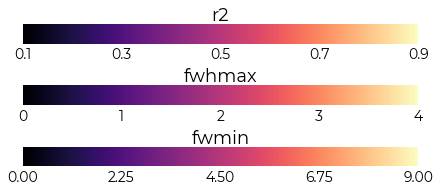

In [34]:
import os
model = 'dog'
ctx_save = pycortex.SavePycortexViews(
    data, 
    subject='sub-001',
    fig_dir=os.path.dirname(prff),
    base_name=f"sub-001_ses-2_task-2R_rois_model-{model}_stage-iter_lbfgs",
    pivot=0,
    radius=260
    )

saving r2
saving fwhmax
saving fwmin
saving /data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/sub001_lbfgs_param/sub-001_ses-2_task-2R_rois_model-dog_stage-iter_lbfgs_desc-brainmaps.pdf


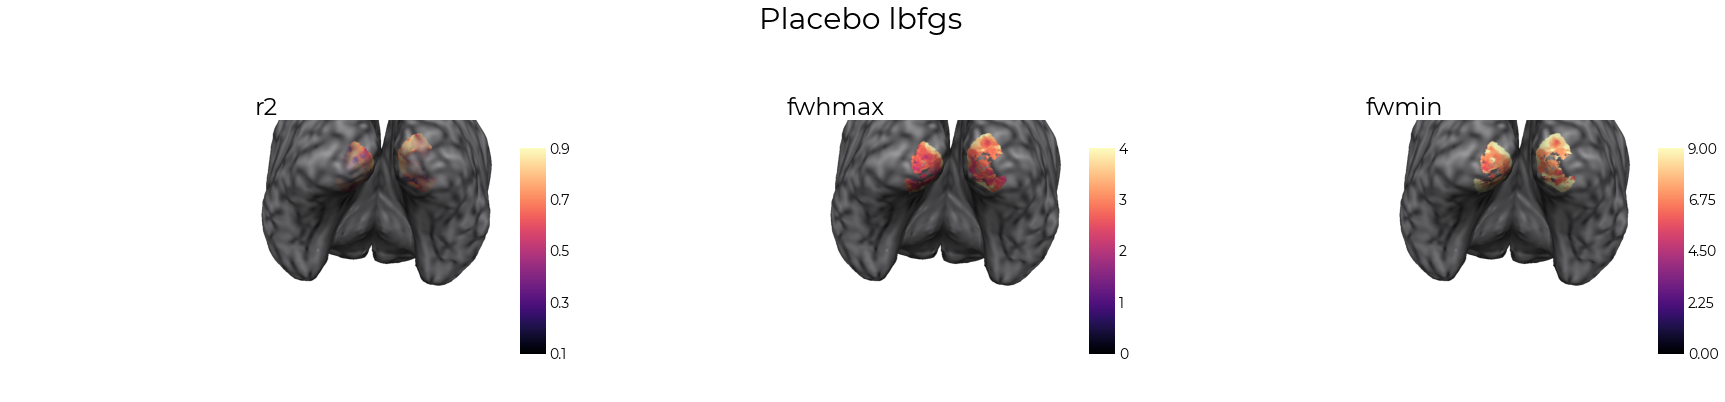

In [43]:

ctx_save.save_all(
    gallery=True, 
    n_cols=4, 
    add_cms=True,
    cb=[0,900,0,1700],
    y=1.08,
    title = 'Placebo lbfgs',
    )

# do it for placebo and memantine

#### Ses-3

In [44]:
model = 'dog'

prf_fn = f"/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-3/sub-001_ses-3_task-2R_roi-v1_model-{model}_stage-iter_desc-prf_params.pkl"
prf_fn33 ='/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-3_train-test/sub-001_ses-3_task-2R_model-dog_stage-iter_desc-prf_params.pkl'
pars3 = prf.Parameters(prf.read_par_file(prf_fn), model=model).to_df()
pars33 = prf.Parameters(prf.read_par_file(prf_fn33), model=model).to_df()

for roi in ['V2', 'V3']:
    prf_fn = f"/data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-3/sub-001_ses-3_task-2R_roi-{roi}_model-{model}_stage-iter_desc-prf_params.pkl"
    parss = prf.Parameters(prf.read_par_file(prf_fn), model=model).to_df()

    pars3.update(parss[parss.r2!=0])

pars3


pars3[pars3.r2!=0] = pars33[pars33.index.isin(pars3[pars3.r2!=0].index)]
print(pars33.loc[21], pars3.loc[21])

parss3 = fwhmax_fwhmin_allvoxels(pars3, model , normalize_RFs=False)

x                    0.341820
y                   -2.859019
prf_size             0.863303
prf_ampl             0.015227
bold_bsl             0.000000
surr_ampl            0.000631
surr_size            8.000001
r2                   0.587422
size ratio           9.266732
suppression index    3.558488
ecc                  2.879381
polar               -1.451803
Name: 21, dtype: float64 x                    0.341820
y                   -2.859019
prf_size             0.863303
prf_ampl             0.015227
bold_bsl             0.000000
surr_ampl            0.000631
surr_size            8.000001
r2                   0.587422
size ratio           9.266732
suppression index    3.558488
ecc                  2.879381
polar               -1.451803
Name: 21, dtype: float64


In [45]:
## getting all the values for plotting the surface (inflated)
polar3 = pycortex.Vertex2D_fix(
    parss3.polar.values,
    data2=parss3.r2.values,
    subject="sub-001",
    cmap="hsvx2",
    vmin1=-3.14,
    vmax1=3.14,
    vmin2=0,
    vmax2=0.8
)

r23_v = pycortex.Vertex2D_fix(
    parss3.r2.values,
    subject="sub-001",
    cmap="magma",
    vmin1=0.1,
    vmax1=0.9
)

fwhmax3 =  pycortex.Vertex2D_fix(
    parss3.fwhmax.values,
    subject="sub-001",
    cmap="magma",
    vmin1=0,
    vmax1=4,
)

if model == 'dog':
    fwmin3 =  pycortex.Vertex2D_fix(
        parss3.fwmin.values,
        subject="sub-001",
        cmap="magma",
        vmin1=0,
        vmax1=9,
    )

ecc3_v = pycortex.Vertex2D_fix(
    parss3.ecc.values,
    data2=parss3.r2.values,
    subject="sub-001",
    cmap="nipy_spectral",
    vmin1=0,
    vmax1=4.5,
    vmin2=0.1,
    vmax2=0.9
)

# v1 = pycortex.Vertex2D_fix(
#     surfsv1.whole_roi,
#     subject="sub-001",
#     cmap="magma",
#     0,
#     1,
# )

# v2 = pycortex.Vertex2D_fix(
#     surfsv2.whole_roi,
#     "sub-001",
#     "magma",
#     0,
#     1,
# )

# v3 = pycortex.Vertex2D_fix(
#     surfsv3.whole_roi,
#     "sub-001",
#     "magma",
#     0,
#     1
# )

if model == 'dog':
    data3 = {
        "r2": r23_v,
        # "v1": v1,
        # "v2": v2,
        # "v3": v3,
        'fwhmax': fwhmax3,
        'fwmin': fwmin3
        }
else:
    data3 = {
        "r2": r23_v,
        "ecc": ecc3_v,
        'polar': polar3,
        # "v1": v1,
        # "v2": v2,
        # "v3": v3,
        'fwhmax': fwhmax3,
        }

Started server on port 47409


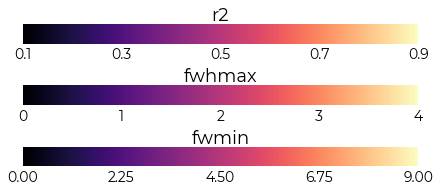

In [46]:
ctx_save3 = pycortex.SavePycortexViews(
    data3, 
    subject='sub-001',
    fig_dir=os.path.dirname(prff),
    base_name=f"sub-001_ses-3_task-2R_rois_model-{model}_stage-iter_lbfgs",
    pivot=0,
    radius=260
    )

saving r2
saving fwhmax
saving fwmin
saving /data1/projects/Meman1/projects/pilot/derivatives/prf/sub-001/ses-2_train-test/sub001_lbfgs_param/sub-001_ses-3_task-2R_rois_model-dog_stage-iter_lbfgs_desc-brainmaps.pdf


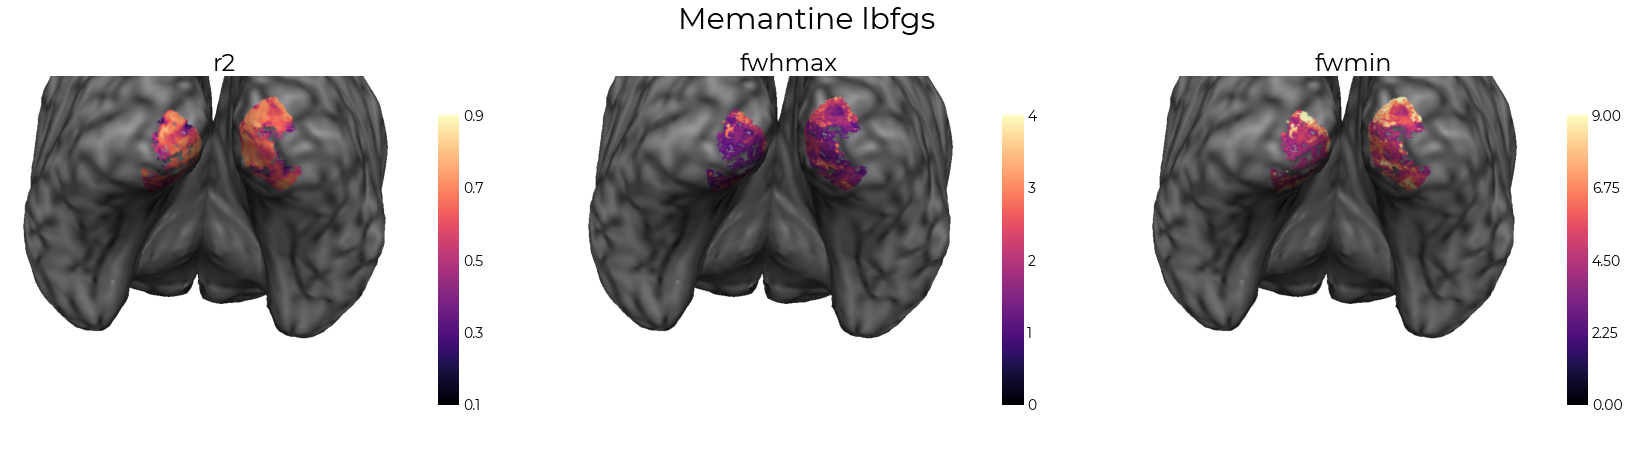

In [49]:
ctx_save3.save_all(
    gallery=True, 
    n_cols=4, 
    add_cms=True,
    cb=[0,800,800,1700], 
    y=1.08,
    title = 'Memantine lbfgs')

## Effects of memantine - DoG-TC and Gaussian

In [3]:
s001_parameters

,x,y,prf_size,prf_ampl,bold_bsl,r2,ecc,polar,roi,session,...,subject,fwhmax,halfmax,model,surr_ampl,surr_size,size ratio,suppression index,fwmin,min_profile
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
768,1.037599,-3.206484,0.705829,0.014764,0.0,0.481263,3.370186,-1.257837,v1,2,...,1,1.641642,0.007379,gauss,NaN,NaN,NaN,NaN,NaN,NaN
769,0.975670,-2.696597,0.710317,0.020780,0.0,0.583112,2.867676,-1.223635,v1,2,...,1,1.641642,0.010386,gauss,NaN,NaN,NaN,NaN,NaN,NaN
773,0.870891,-2.855939,0.762375,0.014564,0.0,0.652380,2.985773,-1.274813,v1,2,...,1,1.801802,0.007279,gauss,NaN,NaN,NaN,NaN,NaN,NaN
774,0.828617,-2.430055,0.676016,0.022889,0.0,0.573926,2.567445,-1.242174,v1,2,...,1,1.561562,0.011440,gauss,NaN,NaN,NaN,NaN,NaN,NaN
778,0.541570,-2.655085,0.775103,0.015876,0.0,0.642469,2.709756,-1.369582,v1,2,...,1,1.801802,0.007935,gauss,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297610,-0.901191,-0.579712,1.939421,0.118270,0.0,0.686646,1.071546,-2.569961,V3,3,...,1,3.083083,7.807808,dog,0.106291,2.059314,1.061819,1.013269,0.005989,-0.002028
297728,-1.090897,-1.884109,1.524309,0.011477,0.0,0.716004,2.177137,-2.095631,V3,3,...,1,3.163163,9.169169,dog,0.002086,5.209093,3.417348,2.122975,0.004695,-0.001292
297918,-1.296108,1.116529,1.540217,0.012964,0.0,0.753589,1.710711,2.430490,V3,3,...,1,3.083083,8.288288,dog,0.003487,3.292622,2.137764,1.229161,0.004738,-0.001232


## Eccentricity check

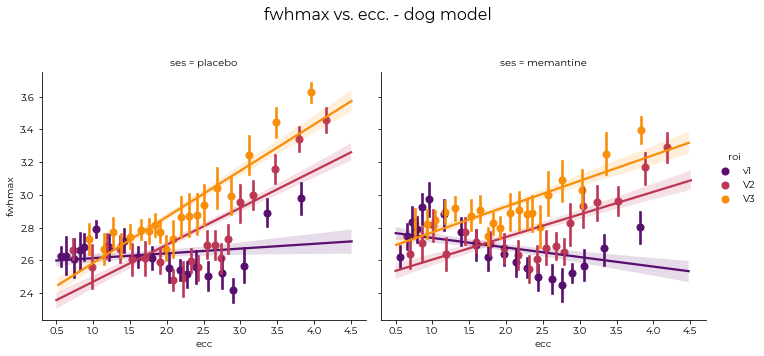

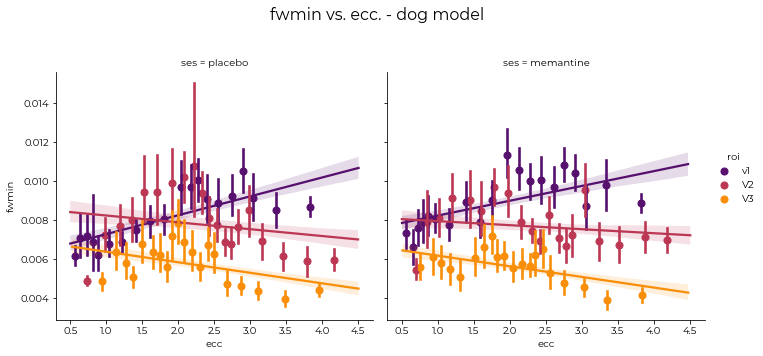

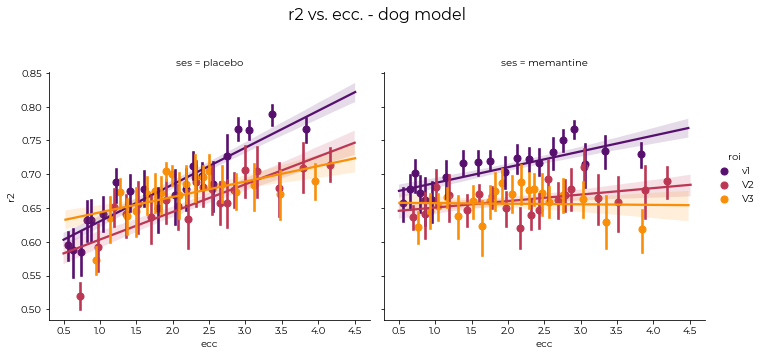

In [54]:
parameters =['fwhmax', 'fwmin', 'r2' ]
model = 'dog'
parameters_subs = s001_parameters[s001_parameters.model=='dog']

for ix, parameter in enumerate(parameters):
    
    a = sns.lmplot(data = parameters_subs, x='ecc', y=parameter, hue = 'roi', col='ses', x_bins = 20, x_ci = 'ci', palette = 'inferno') #'sd' for each bin
    
    a.fig.subplots_adjust(top=.8)
    
    #a.axs(axs[ix])
    
    a.fig.suptitle(f'{parameter} vs. ecc. - {model} model', fontsize = 16)

## FWHM

In [6]:
parameters_subs = pd.read_csv('all_subjects_parameters_dog.csv')

### Fitted

In [8]:
parameters_subs = pd.read_csv('all_subjects_parameters_dog.csv')

data = parameters_subs[parameters_subs.subject ==1]
nbins =15
y = 'yfit'
w = True
par = 'fwhmax'
#model = 'dog'
model = 'dog'
regdf = AllSubjParams(
        data=data, 
        par=par, 
        #roi=roi, 
        nbins=nbins, 
        y=y, 
        w=w, 
        testprint=False,
        fancy=True,
        error="sem",
        sns_offset=4,
        #axs=axs[ix],
        fancy_denom=6,
        label_size=16,
        font_size=20) # points of plot are the bins

v1
v2
v3


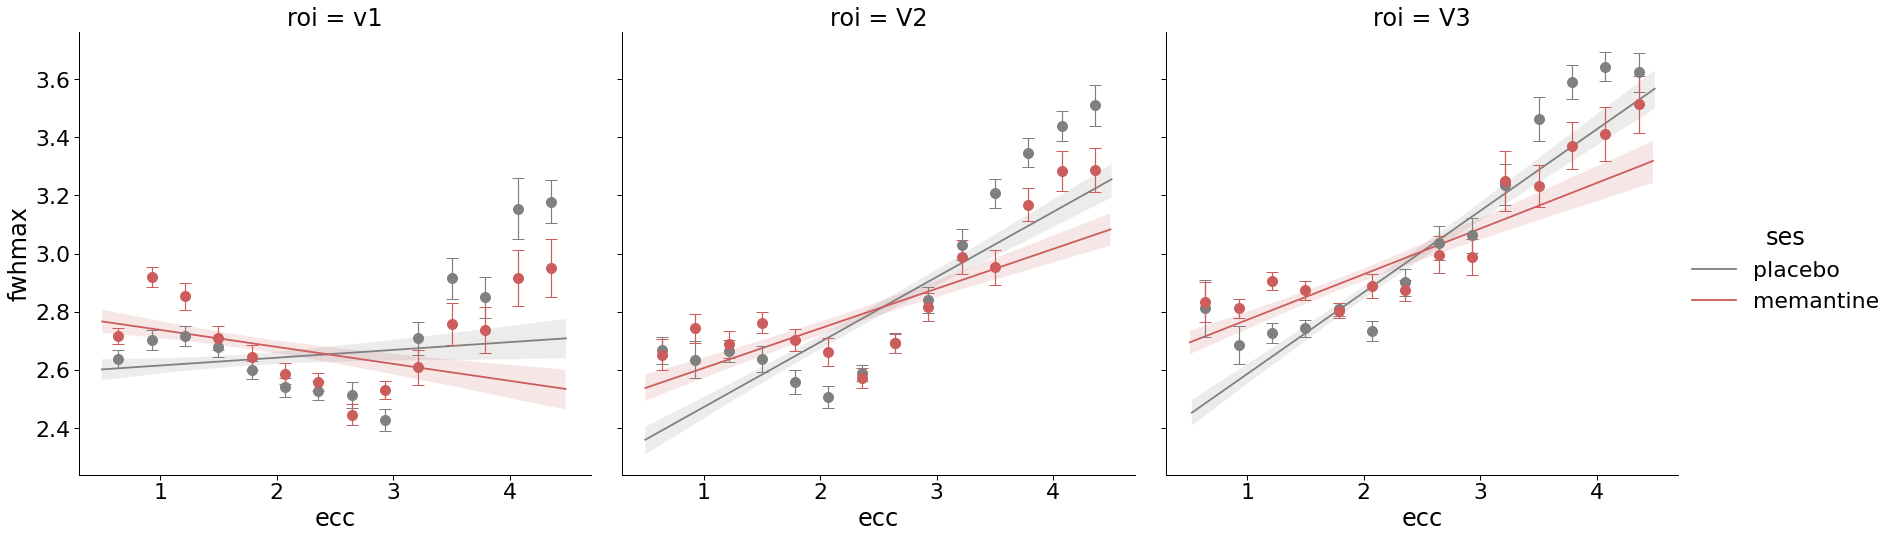

In [9]:
#rois = regdf.df.roi.unique()
pla = regdf.df[regdf.df.ses=='placebo']
mem = regdf.df[regdf.df.ses=='memantine']
#fig,axs = plt.subplots(ncols=1, figsize=(19,8), constrained_layout=True, sharey = True)
parameter = 'fwhmax'
model = 'dog'
sns.set_context('paper',font_scale=2.5)

a = sns.lmplot(data =  parameters_subs[(parameters_subs.ecc>=0.5) & (parameters_subs.ecc<=4.5) & (parameters_subs.subject == 1)], x='ecc', 
                   y = parameter, col= 'roi', hue = 'ses',  x_ci = None, palette =['grey','indianred' ], scatter = False, height= 8)

# axs.errorbar(regdf.x, mem[mem.roi== roi].y, yerr=mem[mem.roi== rois[0]]['std'], fmt="o", c='indianred')
#     axs[i].errorbar(regdf.x, pla[pla.roi== roi].y, yerr=pla[pla.roi== roi]['std'], fmt="o", c='#ccc')
#plt.suptitle('FWHM - DoG model \n \n \n', fontsize = 20)

for i,roi in enumerate(list(parameters_subs.roi.unique())):
    print(roi.lower())
    a.axes[0][i].errorbar(regdf.x, pla[pla.roi== roi].y, yerr=pla[pla.roi== roi]['std'], fmt="o", c='grey', markersize = 10, capsize = 6)
    a.axes[0][i].errorbar(regdf.x, mem[mem.roi== roi].y, yerr=mem[mem.roi== roi]['std'], fmt="o", c='indianred', markersize = 10, capsize = 6)

In [29]:
for roi in ['v1', 'V2', 'V3']:
    for ses in ['placebo', 'memantine']:
        x = parameters_subs[(parameters_subs.ecc>=0.5) & (parameters_subs.ecc<=4.5) & (parameters_subs.subject == 1) 
                            & (parameters_subs.roi == roi) & (parameters_subs.ses == ses)]['ecc']
        X = sm.add_constant(x)

        y = parameters_subs[(parameters_subs.ecc>=0.5) & (parameters_subs.ecc<=4.5) & (parameters_subs.subject == 1)
                            & (parameters_subs.roi == roi) & (parameters_subs.ses == ses)]['fwhmax']

        model = sm.OLS(y, X)

        results = model.fit()

        #(results.summary())

        # Get the coefficients
        slope = results.params[1]
        std_error = results.bse[1]
        df =results.df_resid

        # Calculate the t-statistic and two-sided p-value
        t_statistic = slope / std_error
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df))
        print( roi, ses, ': ','tstat: ',round(t_statistic,3), 'df:', df, 'pval: ',p_value)

v1 placebo :  tstat:  2.54 df: 776.0 pval:  0.011270595488069413
v1 memantine :  tstat:  -5.605 df: 783.0 pval:  2.8906073978873792e-08
V2 placebo :  tstat:  19.717 df: 1008.0 pval:  0.0
V2 memantine :  tstat:  12.334 df: 874.0 pval:  0.0
V3 placebo :  tstat:  21.373 df: 1097.0 pval:  0.0
V3 memantine :  tstat:  12.443 df: 1049.0 pval:  0.0


In [13]:
results.params

const    2.795878
ecc     -0.058424
dtype: float64

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

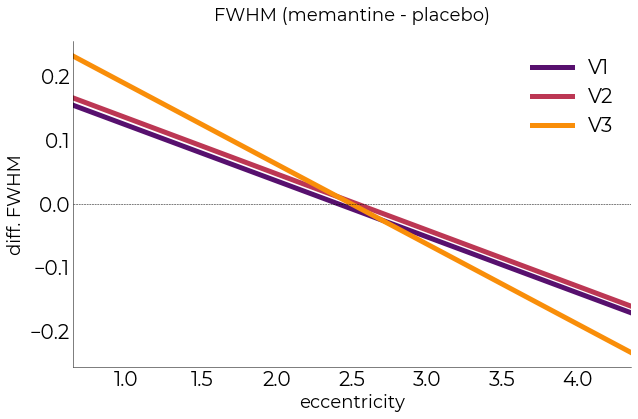

Stopping server
Stopping server
Stopping server
Stopping server


In [80]:
rois = regdf.df.roi.unique()
pla = regdf.df[regdf.df.ses=='placebo']
mem = regdf.df[regdf.df.ses=='memantine']

plotting.LazyPlot(
   ts = [pla[pla.roi== rois[0]].diff_fit ,
         pla[pla.roi== rois[1]].diff_fit ,
         pla[pla.roi== rois[2]].diff_fit
         ],
   xx = regdf.x,
   x_label='eccentricity',
    y_label=f'diff. FWHM',
    title = f'FWHM (memantine - placebo)',
    labels = [ 'V1', 
              'V2', 
              'V3',
                ],
    cmap = 'inferno',
    #color = ['red','orange', 'yellow'],
    # line_width = [0.5, 2, 0.5, 
    #               0.5, 2, 0.5
    #               ,0.5, 2, 0.5,
    #               0.5, 2, 0.5, 
    #                0.5, 2, 0.5,
    #               0.5, 2, 0.5],
#     markers = [, 
#                '.', 
#                '.'],
    #alpha = [0.2, 1, 0.2],
    line_width = 5,
    figsize = [10,6],
    add_hline = 0,
    label_size = 20,
    save_as = f"/data1/projects/Meman1/projects/pilot/code/results_images/difffwhmax_allsub_{model}.jpg"
)
plt.tight_layout

In [24]:
wfwhmax_dogs001
#The weighted-by-R2 average of the FWHM metric, for each bin of eccentric- ity, was statistically tested across V1-V3 for the DoG and Gaussian models. The paired t-test for the Gaussian model re- sulted signicant, allowing us to reject that the condition results come from the same distribution (p = 0.02, t4 = −6.93), while the DoG model tting was not sig- nicant. 

,subject,roi,ses,mean,std
0,1,v1,placebo,2.641541,0.013135
1,1,v1,memantine,2.681199,0.012671
0,1,V2,placebo,2.795608,0.016311
1,1,V2,memantine,2.797750,0.015324
0,1,V3,placebo,2.927256,0.016366
1,1,V3,memantine,2.935087,0.014539


In [23]:
#### paired t-test fwhmax between sessions #####

wfwhmax_dogs001 = mean_std_weightedr2('fwhmax', s001_dog_parameters, plot  = False)
stats.ttest_rel(wfwhmax_dogs001[wfwhmax_dogs001['ses']=='placebo']['mean'], wfwhmax_dogs001[wfwhmax_dogs001['ses']=='memantine']['mean'])

Ttest_relResult(statistic=-1.4172398310210388, pvalue=0.29213786458364566)

In [25]:
#### paired t-test fwhmax between sessions #####

wfwhmax_gs001 = mean_std_weightedr2('fwhmax', s001_gauss_parameters, plot  = False)
stats.ttest_rel(wfwhmax_gs001[wfwhmax_gs001['ses']=='placebo']['mean'], wfwhmax_gs001[wfwhmax_gs001['ses']=='memantine']['mean'])

Ttest_relResult(statistic=-1.968015522396808, pvalue=0.1879264360566226)

(array([ 2.,  0.,  4., 22., 58., 91., 58., 22., 15.,  7.]),
 array([1.72172177, 1.89789795, 2.07407413, 2.2502503 , 2.42642648,
        2.60260266, 2.77877884, 2.95495502, 3.1311312 , 3.30730737,
        3.48348355]),
 <BarContainer object of 10 artists>)

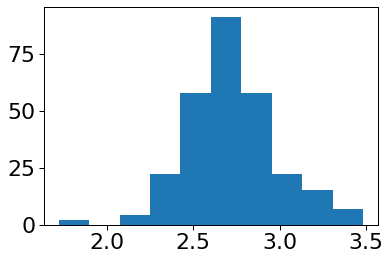

In [34]:
plt.hist(s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='placebo')].fwhmax)

(array([1., 3., 4., 8., 6., 9., 2., 2., 5., 6.]),
 array([2.28228235, 2.37837844, 2.47447453, 2.57057061, 2.6666667 ,
        2.76276278, 2.85885887, 2.95495496, 3.05105104, 3.14714713,
        3.24324322]),
 <BarContainer object of 10 artists>)

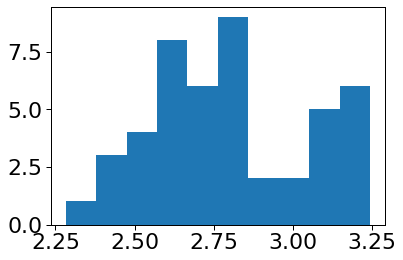

In [36]:
plt.hist(s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='memantine')].fwhmax)

In [46]:
onepointfive_v1_pla = s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='placebo')&(s001_dog_parameters.roi=='v1')].fwhmax

onepointfive_v1_mem = s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='memantine')&(s001_dog_parameters.roi=='v1')].fwhmax

stats.ttest_ind(onepointfive_v1_mem ,onepointfive_v1_pla)

Ttest_indResult(statistic=1.6840602639326139, pvalue=0.09522794400758915)

In [48]:
onepointfive_v2_pla = s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='placebo')&(s001_dog_parameters.roi=='V2')].fwhmax

onepointfive_v2_mem = s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='memantine')&(s001_dog_parameters.roi=='V2')].fwhmax

stats.ttest_ind(onepointfive_v2_mem ,onepointfive_v2_pla)

Ttest_indResult(statistic=0.4232941959186574, pvalue=0.6727910039179512)

(array([ 2.,  0.,  1.,  3., 12., 17., 10., 29.,  6.,  2.]),
 array([1.72172177, 1.87387391, 2.02602606, 2.1781782 , 2.33033035,
        2.48248249, 2.63463464, 2.78678678, 2.93893893, 3.09109107,
        3.24324322]),
 <BarContainer object of 10 artists>)

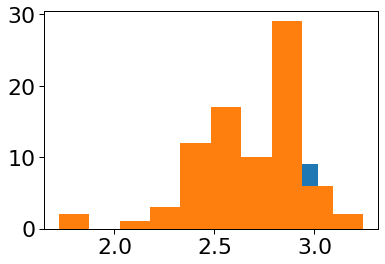

In [56]:
plt.hist(onepointfive_v2_mem)

plt.hist(onepointfive_v2_pla)

In [49]:
onepointfive_v3_pla = s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='placebo')&(s001_dog_parameters.roi=='V3')].fwhmax

onepointfive_v3_mem = s001_dog_parameters[(s001_dog_parameters.ecc>1.21)&(s001_dog_parameters.ecc<1.5)&(s001_dog_parameters.ses=='memantine')&(s001_dog_parameters.roi=='V3')].fwhmax

stats.ttest_ind(onepointfive_v3_mem ,onepointfive_v3_pla)

Ttest_indResult(statistic=3.997659266926184, pvalue=8.91038355900489e-05)

(array([ 2., 11., 35., 12., 36., 14.,  6.,  8., 12.,  3.]),
 array([2.12212205, 2.2582582 , 2.39439435, 2.5305305 , 2.66666665,
        2.8028028 , 2.93893895, 3.0750751 , 3.21121125, 3.3473474 ,
        3.48348355]),
 <BarContainer object of 10 artists>)

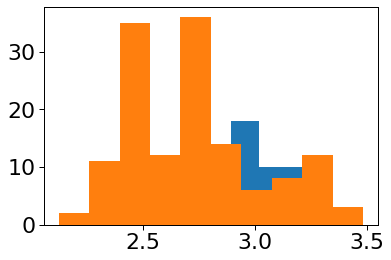

In [55]:
plt.hist(onepointfive_v3_mem)

plt.hist(onepointfive_v3_pla)

Ttest_indResult(statistic=-3.263705892682304, pvalue=0.0023297645463943866)
Ttest_indResult(statistic=-1.680339793333459, pvalue=0.09656295047799485)
Ttest_indResult(statistic=-1.4772909901617368, pvalue=0.1435237007046203)


(array([ 2.,  4.,  7., 10., 10.,  3.,  1.,  4.,  0.,  3.]),
 array([2.60260272, 2.80280292, 3.00300312, 3.20320332, 3.40340352,
        3.60360372, 3.80380392, 4.00400412, 4.20420432, 4.40440452,
        4.60460472]),
 <BarContainer object of 10 artists>)

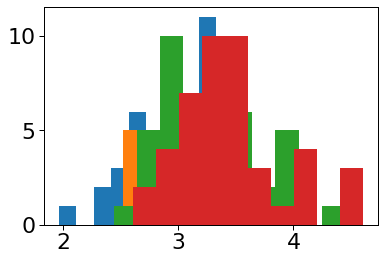

In [57]:
onepointfive_v1_pla = s001_dog_parameters[(s001_dog_parameters.ecc>3.21)&(s001_dog_parameters.ecc<3.5)&(s001_dog_parameters.ses=='placebo')&(s001_dog_parameters.roi=='v1')].fwhmax

onepointfive_v1_mem = s001_dog_parameters[(s001_dog_parameters.ecc>3.21)&(s001_dog_parameters.ecc<3.5)&(s001_dog_parameters.ses=='memantine')&(s001_dog_parameters.roi=='v1')].fwhmax

print(stats.ttest_ind(onepointfive_v1_mem ,onepointfive_v1_pla))
onepointfive_v2_pla = s001_dog_parameters[(s001_dog_parameters.ecc>3.21)&(s001_dog_parameters.ecc<3.5)&(s001_dog_parameters.ses=='placebo')&(s001_dog_parameters.roi=='V2')].fwhmax

onepointfive_v2_mem = s001_dog_parameters[(s001_dog_parameters.ecc>3.21)&(s001_dog_parameters.ecc<3.5)&(s001_dog_parameters.ses=='memantine')&(s001_dog_parameters.roi=='V2')].fwhmax

print(stats.ttest_ind(onepointfive_v2_mem ,onepointfive_v2_pla))
plt.hist(onepointfive_v2_mem)

plt.hist(onepointfive_v2_pla)
onepointfive_v3_pla = s001_dog_parameters[(s001_dog_parameters.ecc>3.21)&(s001_dog_parameters.ecc<3.5)&(s001_dog_parameters.ses=='placebo')&(s001_dog_parameters.roi=='V3')].fwhmax

onepointfive_v3_mem = s001_dog_parameters[(s001_dog_parameters.ecc>3.21)&(s001_dog_parameters.ecc<3.5)&(s001_dog_parameters.ses=='memantine')&(s001_dog_parameters.roi=='V3')].fwhmax

print(stats.ttest_ind(onepointfive_v3_mem ,onepointfive_v3_pla))
plt.hist(onepointfive_v3_mem)

plt.hist(onepointfive_v3_pla)

## FWMIN

### Fitted

In [67]:
parameters_subs = pd.read_csv('all_subjects_parameters_dog.csv')

data = parameters_subs[parameters_subs.subject ==1]
nbins =15
y = 'yfit'
w = True
par = 'fwmin'
#model = 'dog'
model = 'dog'
regdf = AllSubjParams(
        data=data, 
        par=par, 
        #roi=roi, 
        nbins=nbins, 
        y=y, 
        w=w, 
        testprint=False,
        fancy=True,
        error="sem",
        sns_offset=4,
        #axs=axs[ix],
        fancy_denom=6,
        label_size=16,
        font_size=20) # points of plot are the bins

v1
v2
v3


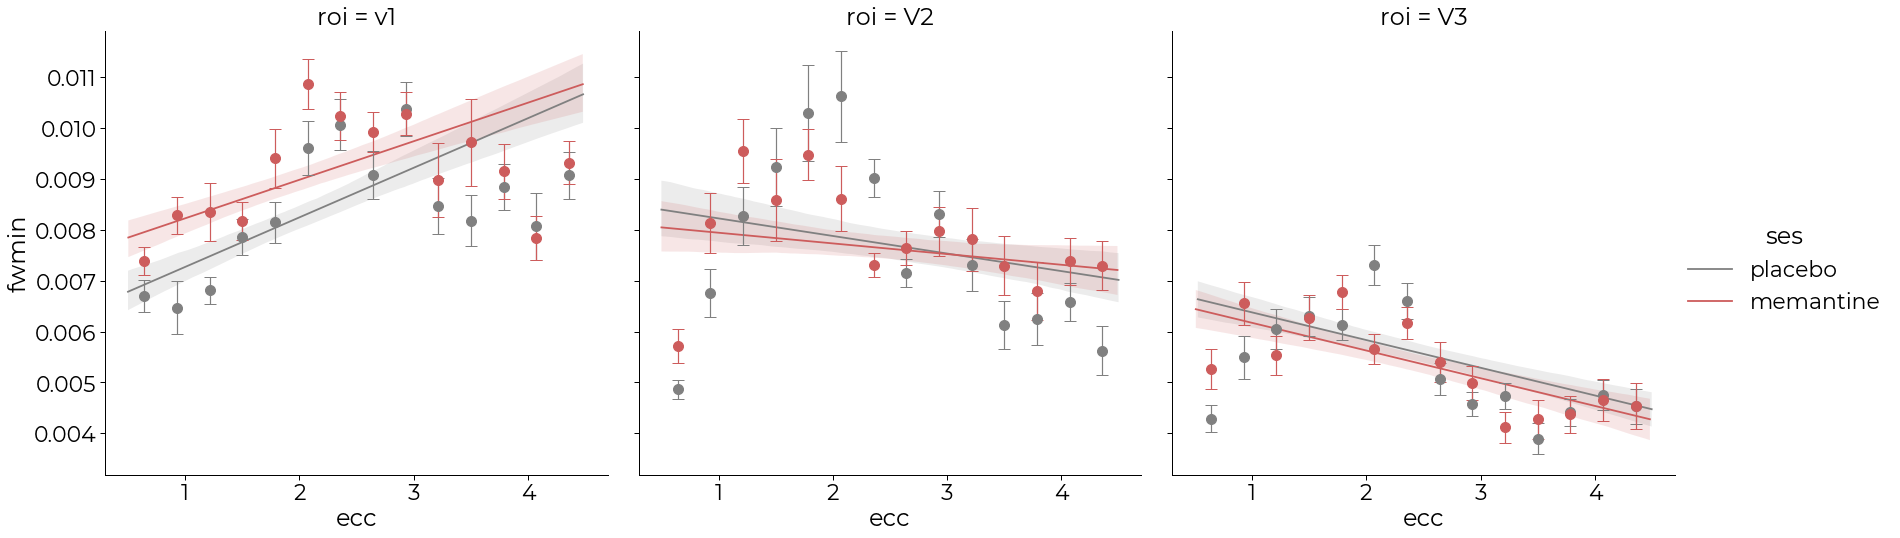

In [68]:
#rois = regdf.df.roi.unique()
pla = regdf.df[regdf.df.ses=='placebo']
mem = regdf.df[regdf.df.ses=='memantine']
#fig,axs = plt.subplots(ncols=1, figsize=(19,8), constrained_layout=True, sharey = True)
parameter = 'fwmin'
model = 'dog'
sns.set_context('paper',font_scale=2.5)

a = sns.lmplot(data =  parameters_subs[(parameters_subs.ecc>=0.5) & (parameters_subs.ecc<=4.5) & (parameters_subs.subject == 1)], x='ecc', 
                   y = parameter, col= 'roi', hue = 'ses',  x_ci = None, palette =['grey','indianred' ], scatter = False, height= 8)

# axs.errorbar(regdf.x, mem[mem.roi== roi].y, yerr=mem[mem.roi== rois[0]]['std'], fmt="o", c='indianred')
#     axs[i].errorbar(regdf.x, pla[pla.roi== roi].y, yerr=pla[pla.roi== roi]['std'], fmt="o", c='#ccc')
#plt.suptitle('FWHM - DoG model \n \n \n', fontsize = 20)

for i,roi in enumerate(list(parameters_subs.roi.unique())):
    print(roi.lower())
    a.axes[0][i].errorbar(regdf.x, pla[pla.roi== roi].y, yerr=pla[pla.roi== roi]['std'], fmt="o", c='grey', markersize = 10, capsize = 6)
    a.axes[0][i].errorbar(regdf.x, mem[mem.roi== roi].y, yerr=mem[mem.roi== roi]['std'], fmt="o", c='indianred', markersize = 10, capsize = 6)

In [33]:
for roi in ['v1', 'V2', 'V3']:
    for ses in ['placebo', 'memantine']:
        x = parameters_subs[(parameters_subs.ecc>=0.5) & (parameters_subs.ecc<=4.5) & (parameters_subs.subject == 1) 
                            & (parameters_subs.roi == roi) & (parameters_subs.ses == ses)]['ecc']
        X = sm.add_constant(x)

        y = parameters_subs[(parameters_subs.ecc>=0.5) & (parameters_subs.ecc<=4.5) & (parameters_subs.subject == 1)
                            & (parameters_subs.roi == roi) & (parameters_subs.ses == ses)]['fwmin']

        model = sm.OLS(y, X)

        results = model.fit()

        #(results.summary())

        # Get the coefficients
        slope = results.params[1]
        std_error = results.bse[1]
        df =results.df_resid

        # Calculate the t-statistic and two-sided p-value
        t_statistic = slope / std_error
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df))
        print( roi, ses, ': ','coef:',round(slope,4),'tstat: ',round(t_statistic,3), 'df:', df, 'pval: ',p_value)

v1 placebo :  coef: 0.001 tstat:  8.351 df: 776.0 pval:  4.440892098500626e-16
v1 memantine :  coef: 0.0008 tstat:  7.084 df: 783.0 pval:  3.113953539468639e-12
V2 placebo :  coef: -0.0003 tstat:  -2.274 df: 1008.0 pval:  0.023197369748380048
V2 memantine :  coef: -0.0002 tstat:  -1.854 df: 874.0 pval:  0.06410563005338576
V3 placebo :  coef: -0.0005 tstat:  -4.931 df: 1097.0 pval:  9.467558135245469e-07
V3 memantine :  coef: -0.0005 tstat:  -5.411 df: 1049.0 pval:  7.773733501359459e-08


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

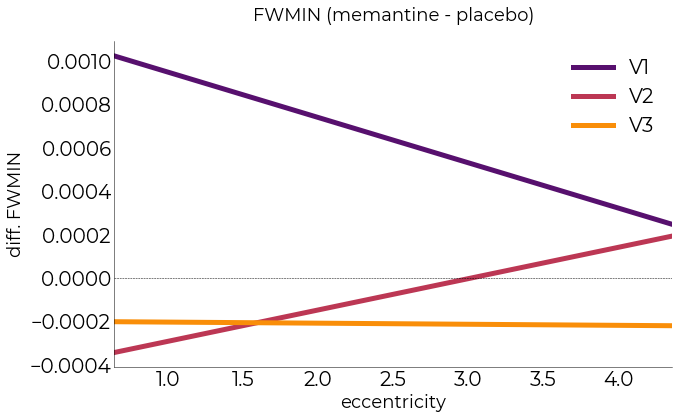

In [70]:
rois = regdf.df.roi.unique()
pla = regdf.df[regdf.df.ses=='placebo']
mem = regdf.df[regdf.df.ses=='memantine']

plotting.LazyPlot(
   ts = [pla[pla.roi== rois[0]].diff_fit ,
         pla[pla.roi== rois[1]].diff_fit ,
         pla[pla.roi== rois[2]].diff_fit
         ],
   xx = regdf.x,
   x_label='eccentricity',
    y_label=f'diff. FWMIN',
    title = f'FWMIN (memantine - placebo)',
    labels = [ 'V1', 
              'V2', 
              'V3',
                ],
    cmap = 'inferno',
    #color = ['red','orange', 'yellow'],
    # line_width = [0.5, 2, 0.5, 
    #               0.5, 2, 0.5
    #               ,0.5, 2, 0.5,
    #               0.5, 2, 0.5, 
    #                0.5, 2, 0.5,
    #               0.5, 2, 0.5],
#     markers = [, 
#                '.', 
#                '.'],
    #alpha = [0.2, 1, 0.2],
    line_width = 5,
    figsize = [10,6],
    add_hline = 0,
    label_size = 20,
    save_as = f"/data1/projects/Meman1/projects/pilot/code/results_images/difffwmin_allsub_{model}.jpg"
)
plt.tight_layout